# Figure for Multiprogramming paper

## Initialization

In [80]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit_aer import AerSimulator, QasmSimulator, Aer
# from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit_ibm_runtime import Sampler, SamplerV2

from datetime import datetime
import mysql.connector
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import json

from qiskit_ibm_runtime.fake_provider import fake_backend

import copy
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.qasm2 import dumps
from qiskit.visualization import plot_circuit_layout
 
from qiskit.circuit.library import RZZGate, RZGate, XGate, IGate
from qiskit.converters import circuit_to_dag, dag_to_circuit

from qiskit.transpiler.passes import ALAPScheduleAnalysis, ASAPScheduleAnalysis, PadDynamicalDecoupling, PadDelay
from qiskit.transpiler import PassManager
import numpy as np
from qiskit.qasm2 import dumps

import mthree

CB_color_cycle = [
    '#006BA4',  # Blue
    '#FF800E',  # Orange
    '#ABABAB',  # Gray
    '#595959',  # Dark Gray
    '#5F9ED1',  # Light Blue
    '#C85200',  # Dark Orange
    '#898989',  # Medium Gray
    '#A2C8EC',  # Pale Blue
    '#FFBC79',  # Light Orange
    '#CFCFCF',  # Light Gray
    '#009E73',  # Green (Colorblind-friendly)
    '#F0E442'   # Yellow (Colorblind-friendly)
]

markers = ['o', 'v', '^', 's', '+', '*', 'x', 'd', '<', '>', 'p']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}

shots = 4000

mysql_config_online = {
    'user': 'handy',
    'password': 'handy',
    'host': 'ec2-16-171-135-24.eu-north-1.compute.amazonaws.com',
    'database': 'calibration_data'
}





In [2]:
import os
import sys

#module_path = os.path.abspath(os.path.join('..', 'functions'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

from commons import (
    used_qubits, sum_middle_digits_dict
)

from commons import (Config, convert_utc_to_local, calculate_time_diff, get_count_1q, get_count_2q, 
    calculate_circuit_cost, get_correct_output_dict, calculate_success_rate_nassc, calculate_success_rate_tvd, 
    calculate_success_rate_polar, calculate_hellinger_distance, calculate_success_rate_tvd_new, 
    convert_to_json, is_mitigated, get_initial_mapping_json, normalize_counts, convert_dict_int_to_binary, reverse_string_keys, convert_dict_binary_to_int,
    sum_middle_digits_dict
)

from wrappers.multiprogramming_wrapper import (
    avoid_simultaneous_cnot, add_zz_on_simultaneous_cnot, 
    build_idle_coupling_map, multiprogram_compilation_qiskit, merge_circuits,
    get_LF_presets_cm
)
from wrappers.polar_wrapper import (
        polar_code_p2, get_logical_error_on_accepted_states, get_q1prep_sr
)

from wrappers.prune_wrapper import (
    create_full_graph, generate_figures, generate_node_errors, generate_edge_errors,
    get_latest_calibration_id, get_edges_threshold, get_readout_threshold, get_LF_qubits
)

from wrappers.dd_wrapper import (
    convert_dt_to_us, count_delay_durations, apply_pad_delay, get_delay_information, get_dd_information, 
    get_delay_and_dd_information_us
)

from wrappers.qiskit_wrapper import (
    apply_dd, get_zz_rates_from_backend_in_hz, get_qubits_T1_T2, get_gates_length, generate_errors_thermal_relaxation, 
generate_thermal_noise_model_on_used_qubits, get_neighbor_zz_rates_by_qubit, create_rzz_operator,
replace_delay_with_rzz
)

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
# token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"
token = "04ede7f82299b792eae4daf3581f62415b3af676370f752f52d40e5851c7201d6e357c36e7bd55e4719c80d66bba7474412253f6c62f0ea7577bf056aa92eb62"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

#hw_name = "ibm_kyiv"
hw_name = "ibm_sherbrooke"
backend = service.backend(hw_name)

sim_ideal = AerSimulator()
sim_noisy = AerSimulator.from_backend(backend)

## change later back to 3
pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

## Calibration Paper Circuits

### Whisker Plot

In [215]:
def get_data_calibration(user_id, circuit_name=None, hw_name=None):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    sql = f"""
    SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name, 
    hw_name, circuit_name, compilation_name, dd_sequence_type, COALESCE(mp_circuits, 0), 
CONCAT(prune_type, "-" , dd_sequence_type) as prune_type, 
success_rate_tvd, circuit_depth, total_two_qubit_gate FROM (
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, mp_circuits, 
COALESCE(prune_type, "no-prune") AS prune_type, 
success_rate_tvd, circuit_depth, total_two_qubit_gate
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" AND circuit_name != "merged"
"""

    if circuit_name != None:
       sql = sql + f""" AND circuit_name LIKE "{circuit_name}" """
    else:
        sql = sql + f"""AND hw_name LIKE "{hw_name}" """

    sql = sql + """ ) X """

    # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()

    chip_name = []
    hw_name = []
    circuit_name = []
    compilation_name = []
    dd_sequence_type = []
    mp_circuits = []
    prune_type = []
    success_rate_tvd = []
    circuit_depth = []
    total_two_qubit_gate = []
    
    for res in results:
        _chip_name, _hw_name, _circuit_name, _compilation_name, _dd_sequence_type, _mp_circuits, _prune_type, _success_rate_tvd, _circuit_depth, _total_two_qubit_gate = res
    
        chip_name.append(_chip_name)
        hw_name.append(_hw_name)
        circuit_name.append(_circuit_name)
        compilation_name.append(_compilation_name)
        dd_sequence_type.append(_dd_sequence_type)
        mp_circuits.append(_mp_circuits)
        prune_type.append(_prune_type)
        success_rate_tvd.append(float(_success_rate_tvd))
        circuit_depth.append(float(_circuit_depth))
        total_two_qubit_gate.append(float(_total_two_qubit_gate))

    df = pd.DataFrame({
        'chip_name': chip_name,
        'hw_name': hw_name,
        'circuit_name': circuit_name,
        'compilation_name': compilation_name,
        'dd_sequence_type': dd_sequence_type,
        'mp_circuits': mp_circuits,
        'prune_type': prune_type,
        'success_rate_tvd': success_rate_tvd,
        'circuit_depth': circuit_depth,
        'total_two_qubit_gate': total_two_qubit_gate,
        })

    return df

In [290]:
import ast 
def get_data_calibration_merged(user_id, circuit_name=None, hw_name=None):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    sql = f"""
    SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name, 
    hw_name, circuit_name, compilation_name, dd_sequence_type, COALESCE(mp_circuits, 0), 
CONCAT(prune_type, "-" , dd_sequence_type) as prune_type, 
success_rate_tvd, success_rate_tvd_json, circuit_depth, total_two_qubit_gate FROM (
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, mp_circuits, 
COALESCE(prune_type, "no-prune") AS prune_type, 
success_rate_tvd, circuit_depth, total_two_qubit_gate, success_rate_tvd_json
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" AND circuit_name = "merged" 
"""

    if circuit_name != None:
       sql = sql + f""" AND circuit_name LIKE "{circuit_name}" """
    else:
        sql = sql + f"""AND hw_name LIKE "{hw_name}" """

    sql = sql + """ ) X """

    
    # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()

    chip_name = []
    hw_name = []
    circuit_name = []
    compilation_name = []
    dd_sequence_type = []
    mp_circuits = []
    prune_type = []
    success_rate_tvd = []
    success_rate_tvd_json = []
    circuit_depth = []
    total_two_qubit_gate = []
    
    for res in results:
        _chip_name, _hw_name, _circuit_name, _compilation_name, _dd_sequence_type, _mp_circuits, _prune_type, _success_rate_tvd, _success_rate_tvd_json, _circuit_depth, _total_two_qubit_gate = res
    
        chip_name.append(_chip_name)
        hw_name.append(_hw_name)
        circuit_name.append(_circuit_name)
        compilation_name.append(_compilation_name)
        dd_sequence_type.append(_dd_sequence_type)
        mp_circuits.append(_mp_circuits)
        prune_type.append(_prune_type)
        success_rate_tvd.append(float(_success_rate_tvd))
        success_rate_tvd_json.append(_success_rate_tvd_json)
        circuit_depth.append(float(_circuit_depth))
        total_two_qubit_gate.append(float(_total_two_qubit_gate))

    df = pd.DataFrame({
        'chip_name': chip_name,
        'hw_name': hw_name,
        'circuit_name': circuit_name,
        'compilation_name': compilation_name,
        'dd_sequence_type': dd_sequence_type,
        'mp_circuits': mp_circuits,
        'prune_type': prune_type,
        'success_rate_tvd': success_rate_tvd,
        'success_rate_tvd_json': success_rate_tvd_json,
        'circuit_depth': circuit_depth,
        'total_two_qubit_gate': total_two_qubit_gate,
        })

    df['success_rate_tvd_json'] = df['success_rate_tvd_json'].apply(ast.literal_eval)

    # Expand the dictionary into multiple rows
    expanded_rows = []
    
    for _, row in df.iterrows():
        for circuit, value in row['success_rate_tvd_json'].items():
            #if circuit == "AND_5":
            #    print(circuit, row['prune_type'], value)
            expanded_rows.append({
                'chip_name': row['chip_name'],
                'hw_name': row['hw_name'],
                'circuit_name': circuit,
                'prune_type': row['prune_type'],
                'success_rate_tvd': value
            })
    
    # Create a new dataframe from expanded rows
    expanded_df = pd.DataFrame(expanded_rows)

    return expanded_df

In [291]:
df = get_data_calibration("4", hw_name="ibm_fez")
df_sum = df.groupby(['circuit_name', "hw_name", 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()
df_sum

,circuit_name,hw_name,prune_type,mean,std
0,AND_5,ibm_fez,cal-avg-no-dd,0.602500,0.045869
1,AND_5,ibm_fez,cal-lcd-no-dd,0.584083,0.053709
2,AND_5,ibm_fez,lf-no-dd,0.573583,0.045349
3,AND_5,ibm_fez,no-prune-no-dd,0.604250,0.034868
4,OR_5,ibm_fez,cal-avg-no-dd,0.706750,0.047030
5,OR_5,ibm_fez,cal-lcd-no-dd,0.714083,0.036839
6,OR_5,ibm_fez,lf-no-dd,0.497000,0.100100
7,OR_5,ibm_fez,no-prune-no-dd,0.757250,0.026339
8,adder_n4,ibm_fez,cal-avg-no-dd,0.834250,0.056092
9,adder_n4,ibm_fez,cal-lcd-no-dd,0.836250,0.070199


In [292]:
df_merged = get_data_calibration_merged("4", hw_name="ibm_fez")

df_merged_sum = df_merged.groupby(['circuit_name', "hw_name", 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()
df_merged_sum

,circuit_name,hw_name,prune_type,mean,std
0,AND_5,ibm_fez,cal-avg-no-dd,0.602667,0.040924
1,AND_5,ibm_fez,cal-lcd-no-dd,0.585500,0.049487
2,AND_5,ibm_fez,lf-no-dd,0.586917,0.041073
3,AND_5,ibm_fez,no-prune-no-dd,0.598167,0.026797
4,OR_5,ibm_fez,cal-avg-no-dd,0.709833,0.050699
5,OR_5,ibm_fez,cal-lcd-no-dd,0.729000,0.043509
6,OR_5,ibm_fez,lf-no-dd,0.503583,0.096463
7,OR_5,ibm_fez,no-prune-no-dd,0.757333,0.017756
8,adder_n4,ibm_fez,cal-avg-no-dd,0.833667,0.059350
9,adder_n4,ibm_fez,cal-lcd-no-dd,0.831667,0.066396


In [298]:
def get_data_calibration_diff(user_id, hw_name):
    df = get_data_calibration(user_id, hw_name=hw_name)
    df_sum = df.groupby(['circuit_name', "hw_name", 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()
    
    df_merged = get_data_calibration_merged(user_id, hw_name=hw_name)
    df_merged_sum = df_merged.groupby(['circuit_name', "hw_name", 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    # Merge both dataframes on circuit_name and prune_type
    merged = df_merged_sum.merge(df_sum, on=['circuit_name', "hw_name", 'prune_type'], suffixes=('_df1', '_df2'))
    
    # Calculate the difference
    merged['mean'] = merged['mean_df1'] - merged['mean_df2']
    merged['std'] = np.abs(merged['std_df1'] - merged['std_df2'])
    
    # Optional: keep only relevant columns
    result = merged[['circuit_name', "hw_name", 'prune_type', 'mean', 'std']]
    return result
    

In [299]:
df_diff = get_data_calibration_diff("4", "%")
df_diff

,circuit_name,hw_name,prune_type,mean,std
0,AND_5,ibm_brisbane,cal-avg-no-dd,0.000600,0.004094
1,AND_5,ibm_brisbane,cal-lcd-no-dd,0.002825,0.000397
2,AND_5,ibm_brisbane,lf-no-dd,0.001250,0.003301
3,AND_5,ibm_brisbane,no-prune-no-dd,-0.002300,0.003483
4,AND_5,ibm_fez,cal-avg-no-dd,0.000167,0.004945
...,...,...,...,...,...
163,toffoli_n3,ibm_sherbrooke,no-prune-no-dd,-0.013050,0.007214
164,toffoli_n3,ibm_torino,cal-avg-no-dd,-0.055333,0.025763
165,toffoli_n3,ibm_torino,cal-lcd-no-dd,-0.048417,0.016111
166,toffoli_n3,ibm_torino,lf-no-dd,-0.082000,0.007036


In [6]:
# "adder_n4", "AND_5", "OR_5", "toffoli_n3", "hs4", "bv4", "fredkin", "merged"

In [7]:
def plot_whisker_cal(user_id, circuit_name=None, hw_name=None):
    df_cal = get_data_calibration(user_id, circuit_name, hw_name)
    
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df_cal, x="prune_type", y="success_rate_tvd", hue="hw_name")
    
    # Labels and title
    plt.xlabel("Prune Type")
    plt.ylabel("Fidelity")
    plt.title(circuit_name)
    plt.grid(axis="y")
    plt.ylim(0, 1)
    
    # plt.legend(title="Hardware Name")
    plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), fancybox=False, shadow=True, ncol=1)
    plt.tight_layout()
    plt.show()

#### Without DD

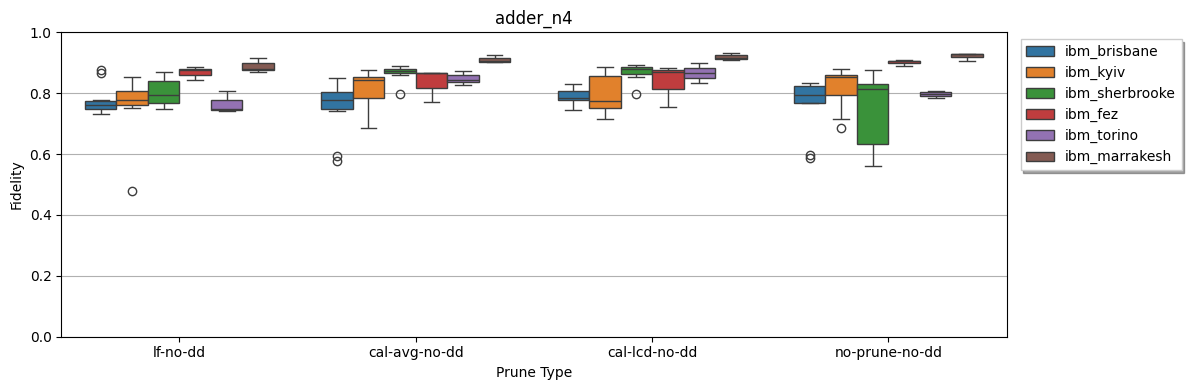

In [8]:
plot_whisker_cal(4, "adder_n4")

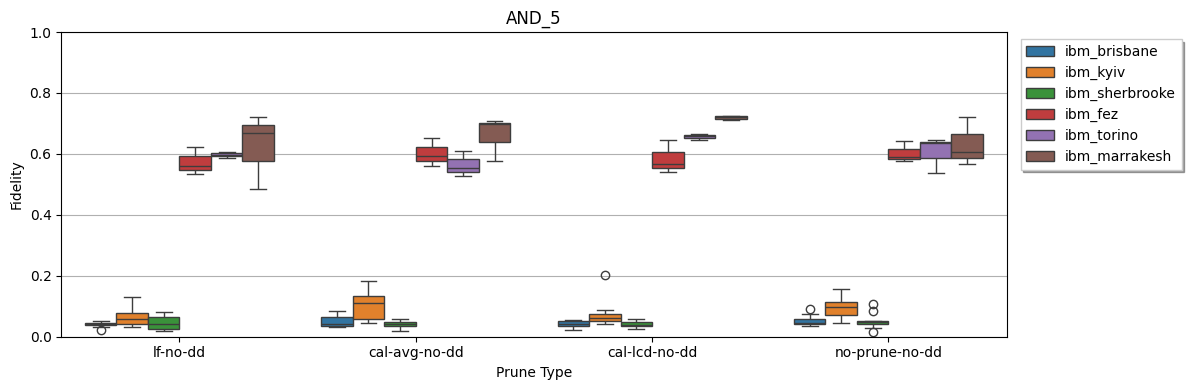

In [9]:
plot_whisker_cal(4, "AND_5", "ibm_kyiv")

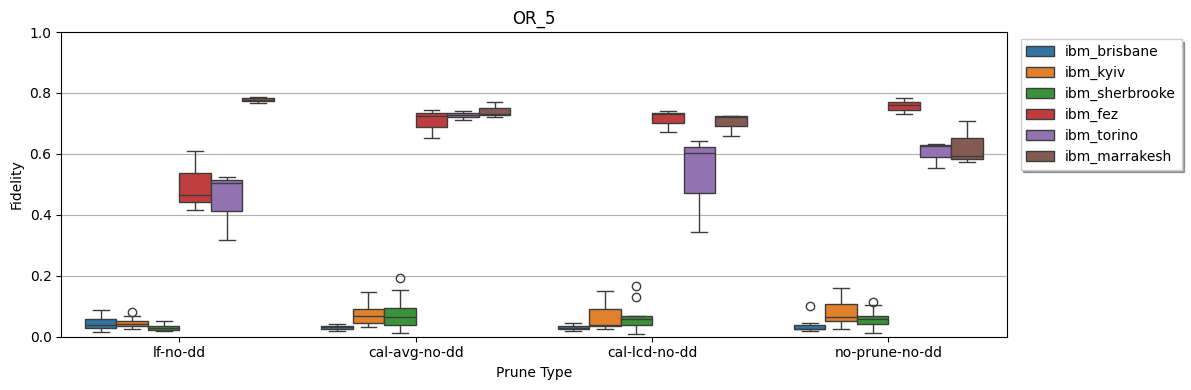

In [10]:
plot_whisker_cal(4, "OR_5", "ibm_kyiv")

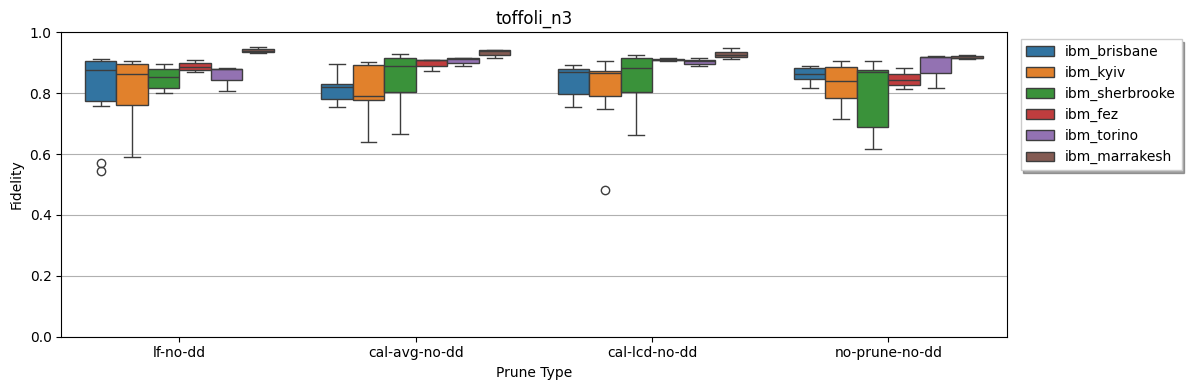

In [11]:
plot_whisker_cal(4, "toffoli_n3", "ibm_kyiv")

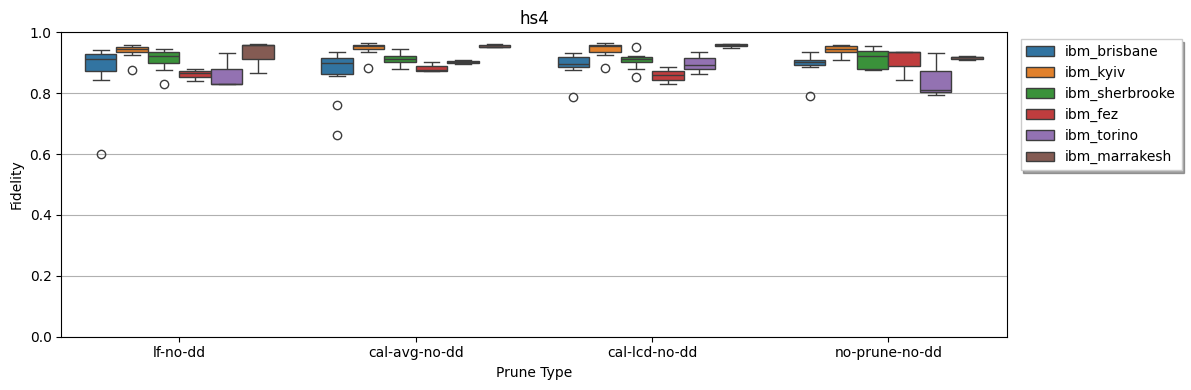

In [12]:
plot_whisker_cal(4, "hs4", "ibm_kyiv")

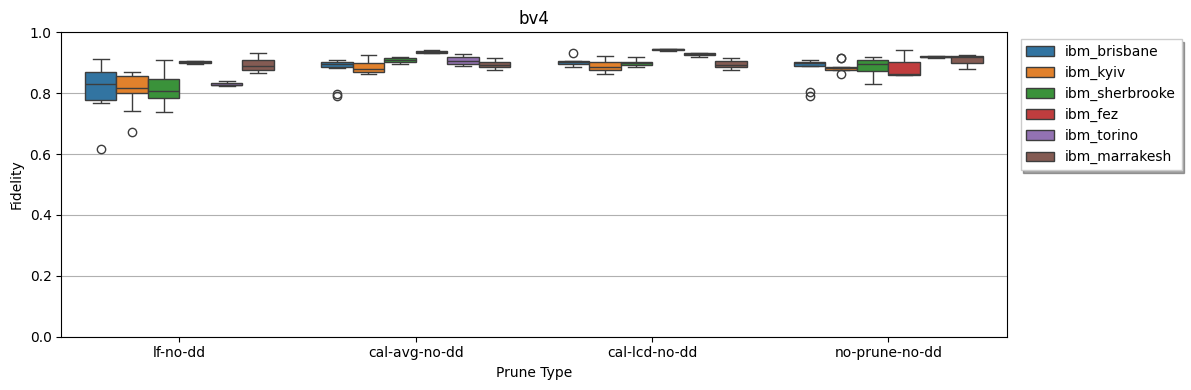

In [13]:
plot_whisker_cal(4, "bv4", "ibm_kyiv")

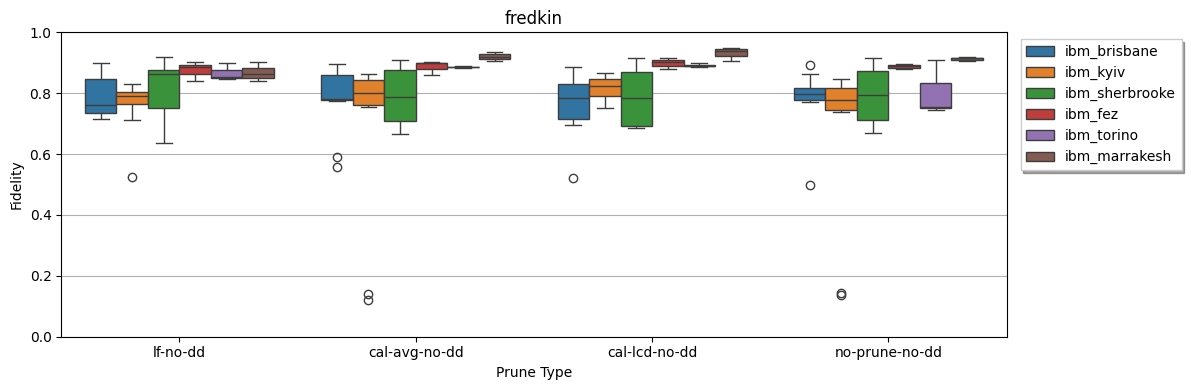

In [14]:
plot_whisker_cal(4, "fredkin", "ibm_kyiv")

/tmp/ipykernel_169905/2352839699.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), fancybox=False, shadow=True, ncol=1)


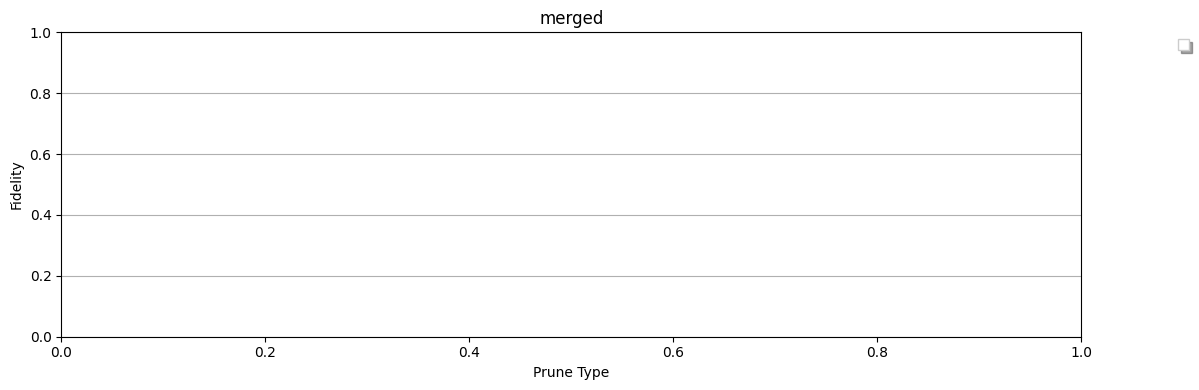

In [15]:
plot_whisker_cal(4, "merged", "ibm_kyiv")

#### With DD

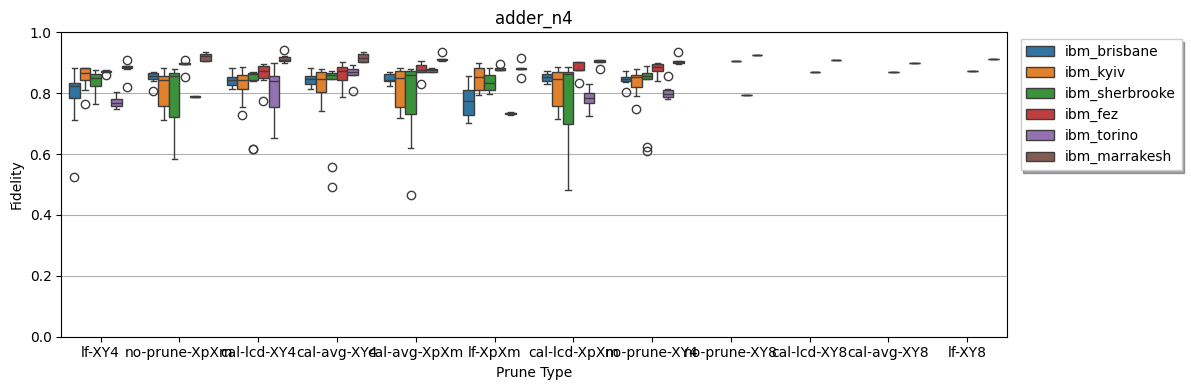

In [16]:
plot_whisker_cal(6, "adder_n4", "ibm_kyiv")

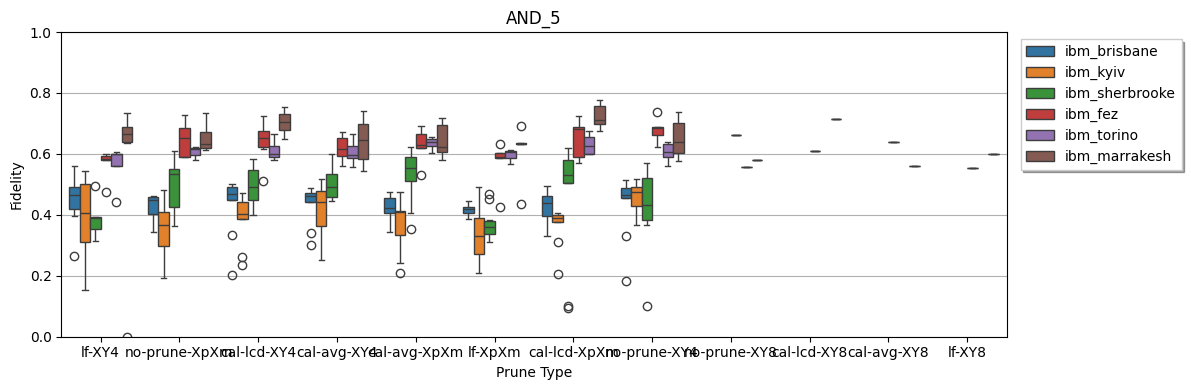

In [17]:
plot_whisker_cal(6, "AND_5", "ibm_kyiv")

### Summary Plot

In [328]:
def show_summary_bar_lines(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0,
                          file_name="", xlabel = None):
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))
    
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 0
            
        opt_data = df[df['prune_type'] == opt]
        # print(opt)
        # print(opt_data)
        # print(CB_color_cycle[i + color_idx_add], i + color_idx_add)
        rects = ax.bar(x + i * width, opt_data['mean'], yerr=opt_data['std'], 
                       color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends, bbox_to_anchor=(1.01, 1))
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
    # ax.legend()

    if xlabel:
        plt.xlabel(xlabel)
        
    plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig("./{}.png".format(file_name), dpi=200)
    plt.show()

In [19]:
def plot_summary_by_circuit_name(user_id, circuit_name, xlabel=None):
    df_cal = get_data_calibration(user_id, circuit_name)

    df_cal_summary = df_cal.groupby(['chip_name', 'hw_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    hw_names = df_cal_summary['hw_name'].unique()
    
    opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
            'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
            'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
            'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
           ]
    legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
               'LF', 'LF-XpXm', 'LF-XY4', 
               "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
               "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
              ]

    show_summary_bar_lines(df_cal_summary, opts, legends, hw_names, [0,1], "Mean fidelity", (13,5), width=0.075, xlabel=xlabel)
    

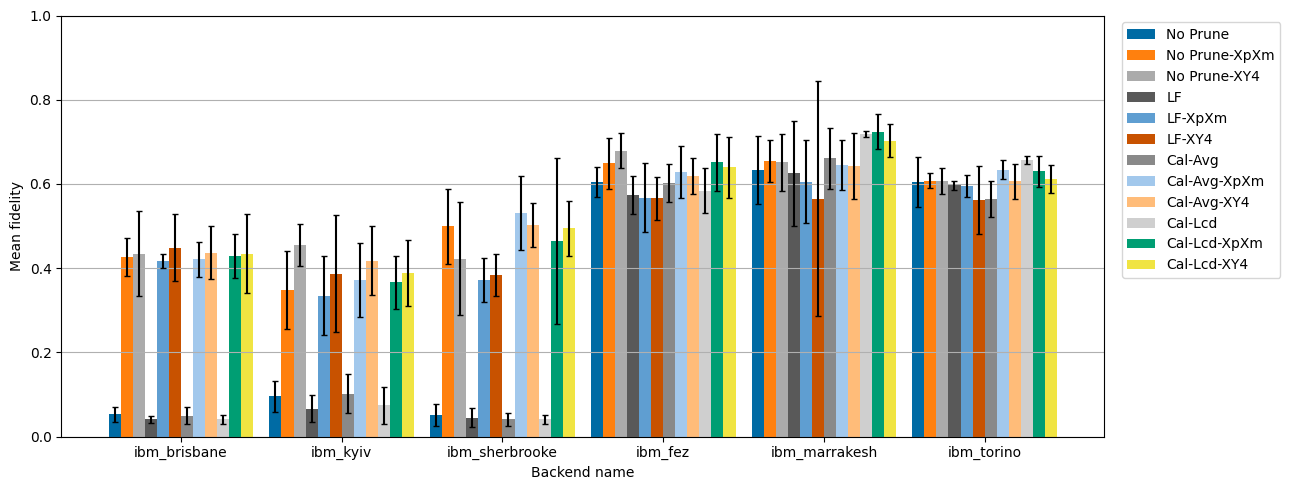

In [20]:
plot_summary_by_circuit_name("4,6", "AND_5", xlabel="Backend name")

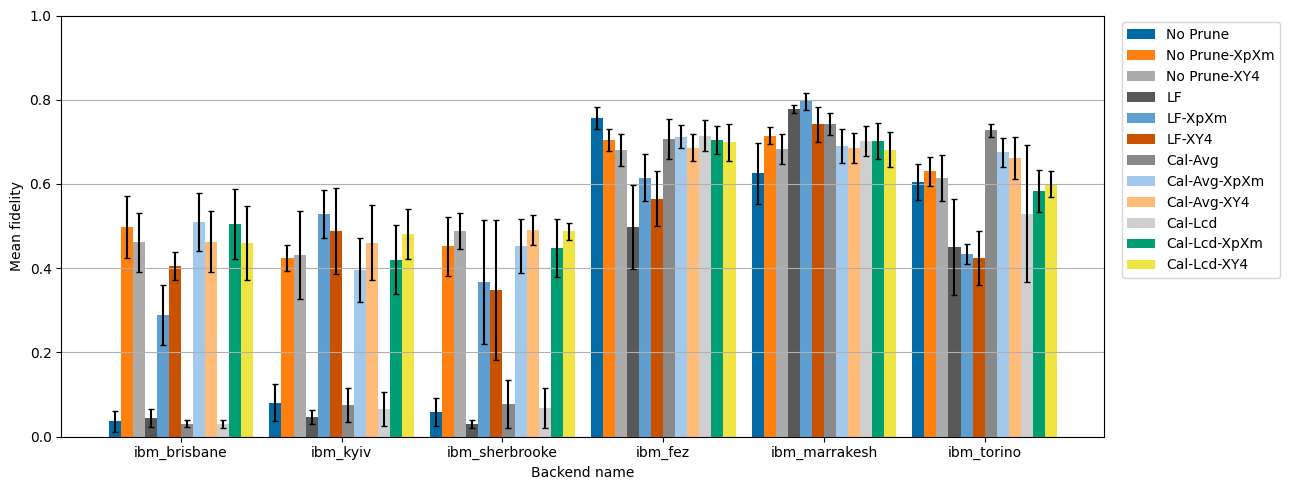

In [21]:
plot_summary_by_circuit_name("4,6", "OR_5", xlabel="Backend name")

#### Plot Normal by hw single

In [22]:
def plot_summary_by_hw(user_id, hw_name, xlabel=None):
    df_cal_kyiv = get_data_calibration(user_id, hw_name=hw_name)

    df_cal_kyiv_summary = df_cal_kyiv.groupby(['mp_circuits', 'circuit_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    circuits = df_cal_kyiv_summary['circuit_name'].unique()

    #opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
    #        'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
    #        'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
    #        'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
    #       ]
    #legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
    #           'LF', 'LF-XpXm', 'LF-XY4', 
    #           "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
    #           "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
    #          ]
    
    opts = ['no-prune-no-dd',
            'lf-no-dd',
            'cal-avg-no-dd',
            'cal-lcd-no-dd'
           ]
    legends = ["No Prune", 
               'LF', 
               "Cal-Avg", 
               "Cal-Lcd", 
              ]

    show_summary_bar_lines(df_cal_kyiv_summary, opts, legends, circuits, [0,1], "Mean fidelity", (8,5), width=0.2, xlabel=xlabel)
    
    

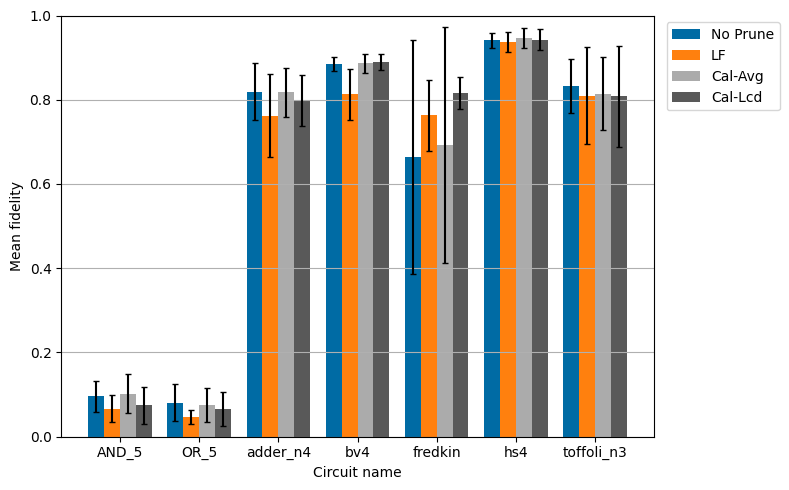

In [23]:
plot_summary_by_hw("4,6", "ibm_kyiv", xlabel="Circuit name")

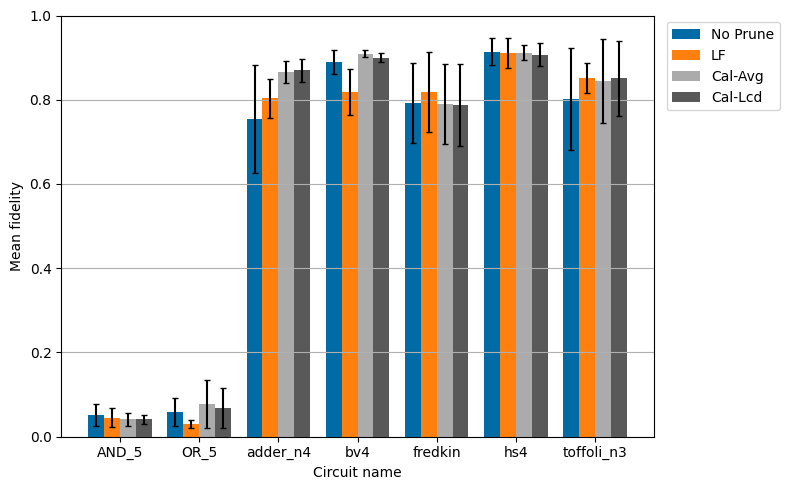

In [24]:
plot_summary_by_hw("4,6", "ibm_sherbrooke", xlabel="Circuit name")

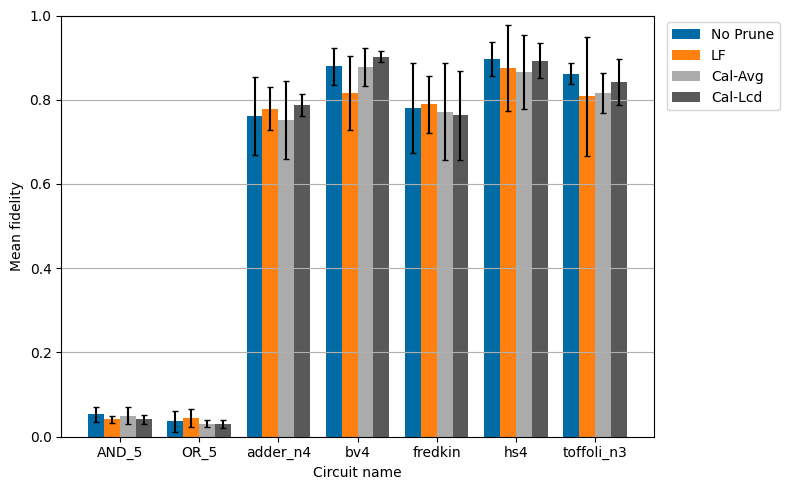

In [25]:
plot_summary_by_hw("4,6", "ibm_brisbane", xlabel="Circuit name")

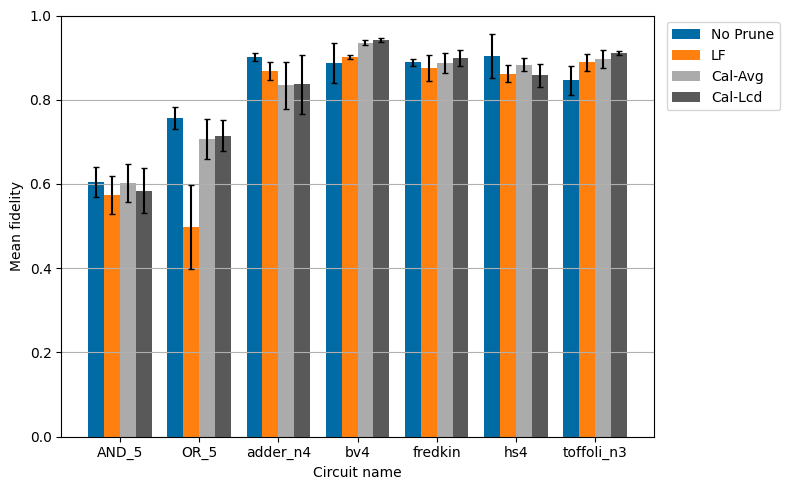

In [26]:
plot_summary_by_hw("4,6", "ibm_fez", xlabel="Circuit name")

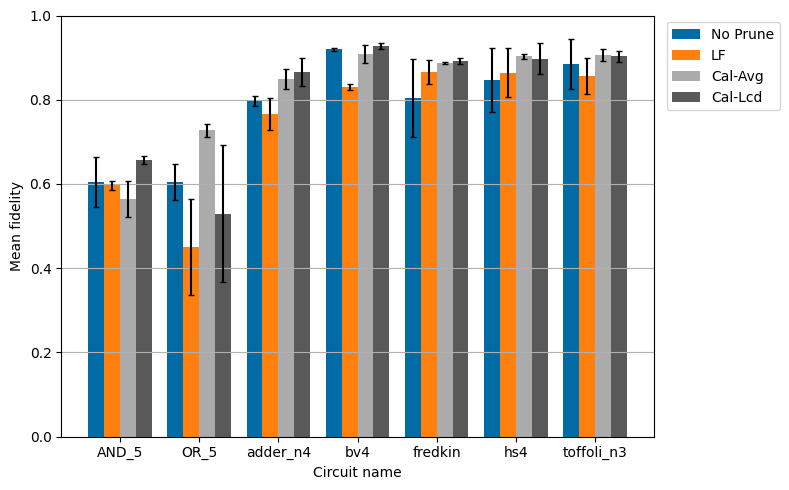

In [27]:
plot_summary_by_hw("4,6", "ibm_torino", xlabel="Circuit name")

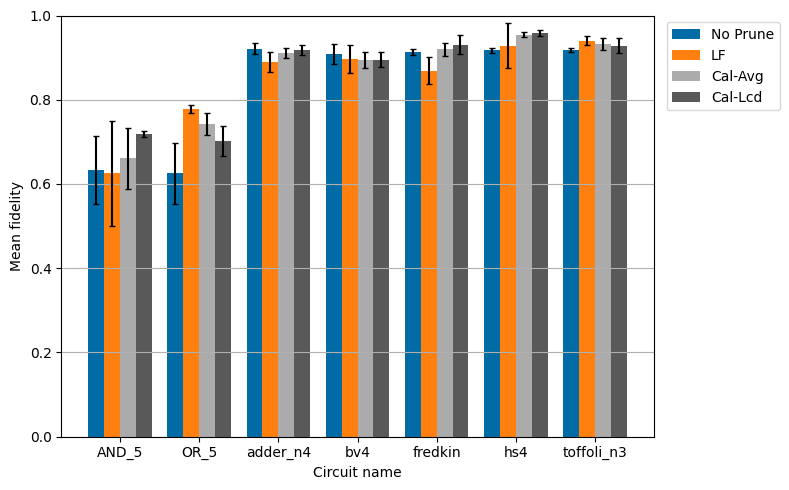

In [28]:
plot_summary_by_hw("4,6", "ibm_marrakesh", xlabel="Circuit name")

#### Compare Isolated vs Multiprogramming

In [318]:
def show_summary_bar_lines_all_hw(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0,
                          file_name="", xlabel = None):
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))
    
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 0
            
        opt_data = df[df['hw_name'] == opt]
        # print(opt)
        # print(opt_data)
        # print(CB_color_cycle[i + color_idx_add], i + color_idx_add)
        rects = ax.bar(x + i * width, opt_data['mean'], yerr=opt_data['std'], 
                       color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends, bbox_to_anchor=(1.01, 1))
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
    # ax.legend()

    if xlabel:
        plt.xlabel(xlabel)
        
    plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig("./{}.png".format(file_name), dpi=200)
    plt.show()

In [319]:
def plot_summary_by_hw_diff_normal(user_id, hw_name, xlabel=None):
    df_cal_kyiv = get_data_calibration_diff(user_id, hw_name=hw_name)
    df_cal_kyiv = df_cal_kyiv[df_cal_kyiv["prune_type"] == "no-prune-no-dd"]

    df_cal_kyiv_summary = df_cal_kyiv.groupby(['circuit_name', 'hw_name'])['mean'].agg(['mean', 'std']).reset_index()

    #df_cal_kyiv_summary = df_cal_kyiv
    
    circuits = df_cal_kyiv_summary['circuit_name'].unique()

    #opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
    #        'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
    #        'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
    #        'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
    #       ]
    #legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
    #           'LF', 'LF-XpXm', 'LF-XY4', 
    #           "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
    #           "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
    #          ]
    
    opts = ['ibm_brisbane',
            'ibm_sherbrooke',
            'ibm_kyiv',
            'ibm_torino',
            'ibm_marrakesh',
            'ibm_fez',
           ]
    legends = ['ibm_brisbane',
            'ibm_sherbrooke',
            'ibm_kyiv',
            'ibm_torino',
            'ibm_marrakesh',
            'ibm_fez',
              ]

    show_summary_bar_lines_all_hw(df_cal_kyiv_summary, opts, legends, circuits, [-0.1,0.1], "Mean fidelity", (8,5), 
                           width=0.15, xlabel=xlabel, legend_position=(0.02, 0.65), file_name="comparing_isolated_vs_multiprog_all_hw")
    
    

In [320]:
#df_cal_kyiv = get_data_calibration_diff("4", hw_name="%")
#df_cal_kyiv[df_cal_kyiv["prune_type"] == "no-prune-no-dd"].head()

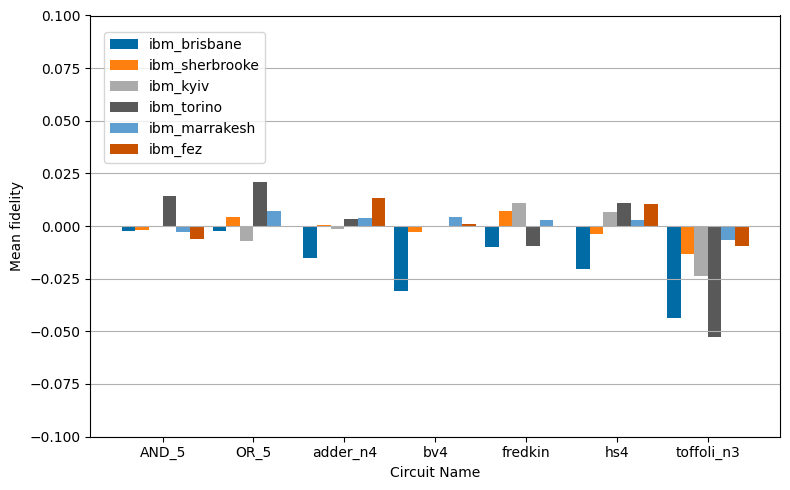

In [336]:
plot_summary_by_hw_diff_normal(4, "%", "Circuit Name")

#### Plot Normal by hw diff

In [449]:
def plot_summary_by_hw_diff(user_id, hw_name, xlabel=None):
    df_cal_kyiv = get_data_calibration_diff(user_id, hw_name=hw_name)

    #df_cal_kyiv_summary = df_cal_kyiv.groupby(['circuit_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    df_cal_kyiv_summary = df_cal_kyiv
    circuits = df_cal_kyiv_summary['circuit_name'].unique()

    #opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
    #        'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
    #        'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
    #        'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
    #       ]
    #legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
    #           'LF', 'LF-XpXm', 'LF-XY4', 
    #           "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
    #           "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
    #          ]


    opts = ['no-prune-XpXm',
            'lf-XpXm',
            'cal-avg-XpXm',
            'cal-lcd-XpXm'
           ]
    
    #opts = ['no-prune-no-dd',
    #        'lf-no-dd',
    #        'cal-avg-no-dd',
    #        'cal-lcd-no-dd'
    #       ]
    legends = ["No-Prune", 
               'LF', 
               "Cal-Avg", 
               "Cal-Lcd", 
              ]

    show_summary_bar_lines(df_cal_kyiv_summary, opts, legends, circuits, [-0.125,0.05], "Mean fidelity", (7,4), 
                           width=0.2, xlabel=xlabel, legend_position=(0.418, 0.08), file_name=f"prune_result_diff_{hw_name}")
    
    

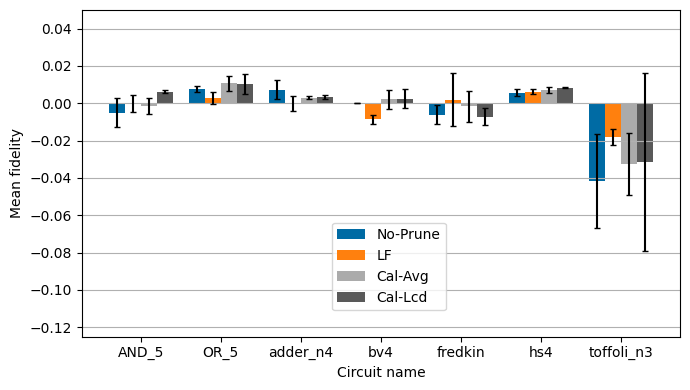

In [450]:
plot_summary_by_hw_diff("4,6", "ibm_kyiv", xlabel="Circuit name")

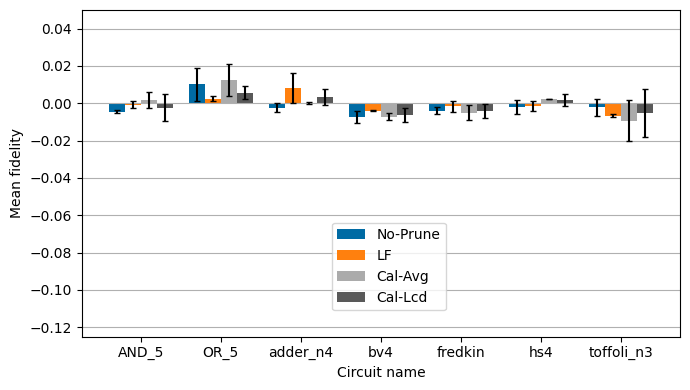

In [451]:
plot_summary_by_hw_diff("4,6", "ibm_sherbrooke", xlabel="Circuit name")

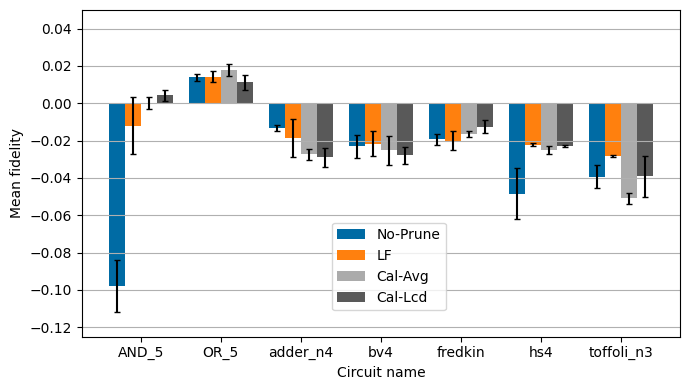

In [457]:
plot_summary_by_hw_diff("6", "ibm_brisbane", xlabel="Circuit name")

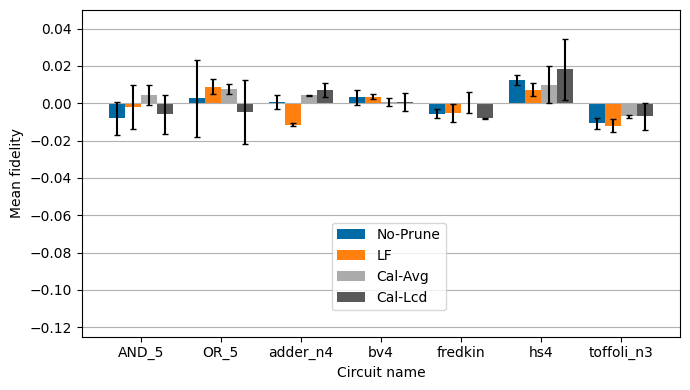

In [453]:
plot_summary_by_hw_diff("4,6", "ibm_fez", xlabel="Circuit name")

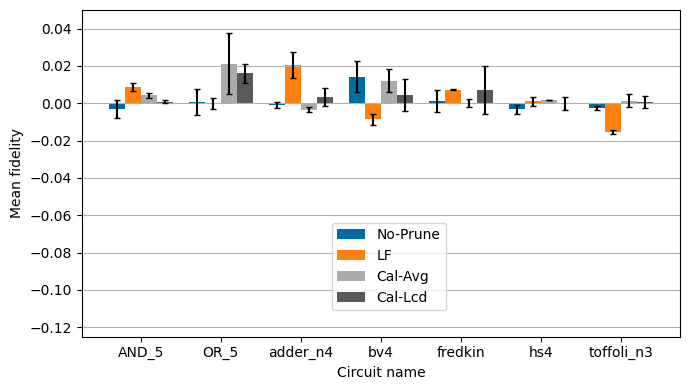

In [454]:
plot_summary_by_hw_diff("4,6", "ibm_marrakesh", xlabel="Circuit name")

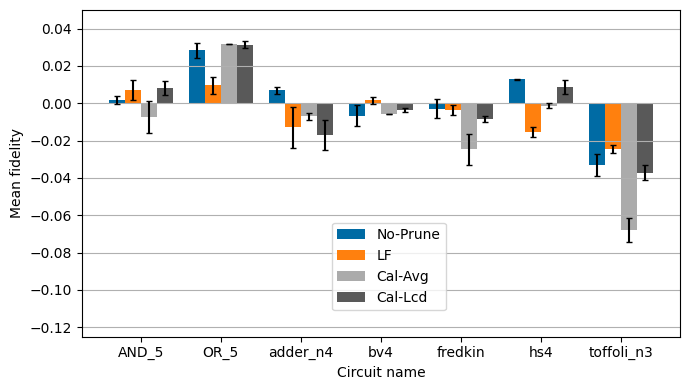

In [455]:
plot_summary_by_hw_diff("4,6", "ibm_torino", xlabel="Circuit name")

#### Plot DD Qiskit-3 by hw

In [29]:
def plot_summary_by_hw_dd(user_id, hw_name, xlabel=None):
    df_cal_kyiv = get_data_calibration(user_id, hw_name=hw_name)

    df_cal_kyiv_summary = df_cal_kyiv.groupby(['mp_circuits', 'circuit_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    circuits = df_cal_kyiv_summary['circuit_name'].unique()
    
    opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4'
           ]
    legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4"
              ]

    show_summary_bar_lines(df_cal_kyiv_summary, opts, legends, circuits, [0,1], "Mean fidelity", (8,5), width=0.2, xlabel=xlabel)

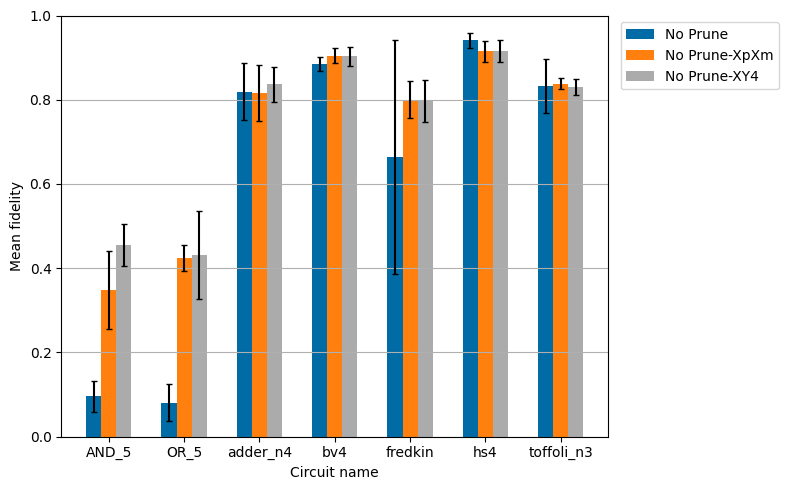

In [30]:
plot_summary_by_hw_dd("4,6", "ibm_kyiv", xlabel="Circuit name")

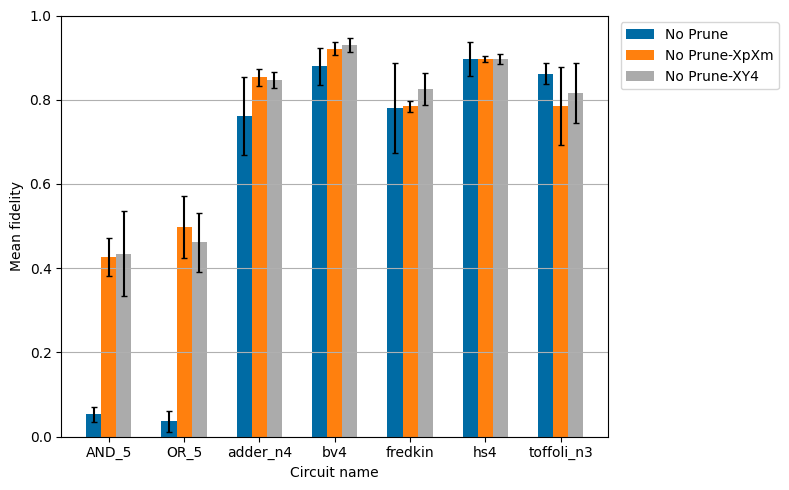

In [31]:
plot_summary_by_hw_dd("4,6", "ibm_brisbane", xlabel="Circuit name")

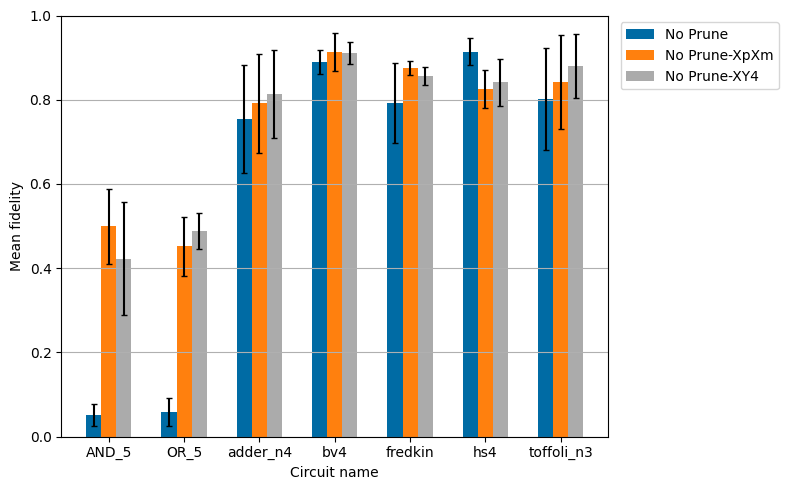

In [32]:
plot_summary_by_hw_dd("4,6", "ibm_sherbrooke", xlabel="Circuit name")

## State Preparation Polar Code

In [33]:
def get_data_polar(user_id, circuit_name, type="avg", hw_name="ibm_kyiv"):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    if type == "avg":
        sql = f"""
SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name,
hw_name, circuit_name, compilation_name, dd_sequence_type, COALESCE(mp_circuits, 0), 
CONCAT(prune_type, "-", dd_sequence_type) as prune_type, 
(total_shots), (polar_count_accept), (polar_count_accept) / (total_shots) * 100 as prep_rate
FROM(
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, 
COALESCE(mp_circuits, 0) as mp_circuits, 
COALESCE(prune_type, "no-prune") as prune_type, prune_parameters, CASE WHEN mp_circuits IS NULL THEN 0 ELSE 1 END as mp,  
(shots * COALESCE(mp_circuits,1)) as total_shots,  (polar_count_accept)
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" 
AND hw_name != "ibm_brisbane" AND circuit_name = "{circuit_name}") X
WHERE mp = 1 
ORDER BY hw_name; 
        """
    else:
        sql = f"""
    SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name,
hw_name, circuit_name, compilation_name, dd_sequence_type, COALESCE(mp_circuits, 0), 
CONCAT(prune_type, "-", dd_sequence_type) as prune_type, 
(total_shots), (polar_count_accept), (polar_count_accept) / (total_shots) * 100 as prep_rate
FROM(
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, 
COALESCE(mp_circuits, 0) as mp_circuits, 
COALESCE(prune_type, "no-prune") as prune_type, prune_parameters, CASE WHEN mp_circuits IS NULL THEN 0 ELSE 1 END as mp,   
(shots ) as total_shots,  (polar_count_accept)
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" 
AND hw_name != "ibm_brisbane" AND circuit_name = "{circuit_name}") X
WHERE mp = 1 
ORDER BY hw_name; 
            """

     # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()

    chip_name = []
    hw_name = []
    circuit_name = []
    compilation_name = []
    dd_sequence_type = []
    mp_circuits = []
    prune_type = []
    total_shots = []
    total_accept = []
    prep_rate = []
    
    for res in results:
        _chip_name, _hw_name, _circuit_name, _compilation_name, _dd_sequence_type, _mp_circuits, _prune_type, _total_shots, _total_accept, _prep_rate = res
    
        chip_name.append(_chip_name)
        hw_name.append(_hw_name)
        circuit_name.append(_circuit_name)
        compilation_name.append(_compilation_name)
        dd_sequence_type.append(_dd_sequence_type)
        mp_circuits.append(_mp_circuits)
        prune_type.append(_prune_type)
        total_shots.append(float(_total_shots))
        total_accept.append(float(_total_accept))
        prep_rate.append(float(_prep_rate))

    df = pd.DataFrame({
        'chip_name': chip_name,
        'hw_name': hw_name,
        'circuit_name': circuit_name,
        'compilation_name': compilation_name,
        'dd_sequence_type': dd_sequence_type,
        'mp_circuits': mp_circuits,
        'prune_type': prune_type,
        'total_shots': total_shots,
        'total_accept': total_accept,
        'prep_rate': prep_rate,
        })

    return df

In [34]:
def plot_polar_prep_rate(user_id, circuit_name, type, ylim, show_data="all", xlabel=None):
    df_polar = get_data_polar(user_id, circuit_name, type)
    df_polar_summary = df_polar.groupby(['chip_name', 'hw_name', 'prune_type'])['prep_rate'].agg(['mean', 'std']).reset_index()

    hw_names = df_polar_summary['hw_name'].unique()

    if show_data == "all":
        opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
            'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
            'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
            'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
           ]
        legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
                   'LF', 'LF-XpXm', 'LF-XY4', 
                   "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
                   "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
                  ]
    elif show_data == "prune":
        opts = ['no-prune-no-dd',
                'lf-no-dd', 
                'cal-avg-no-dd', 
                'cal-lcd-no-dd', 
               ]
        legends = ["No Prune", 
                   'LF', 
                   "Cal-Avg", 
                   "Cal-Lcd"
                  ]
    else:
        opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4'
           ]
        legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4"
                  ]
        
    
    show_summary_bar_lines(df_polar_summary, opts, legends, hw_names, ylim, "Mean Prep Rate (avg)", (6,5), width=0.2, xlabel=xlabel)


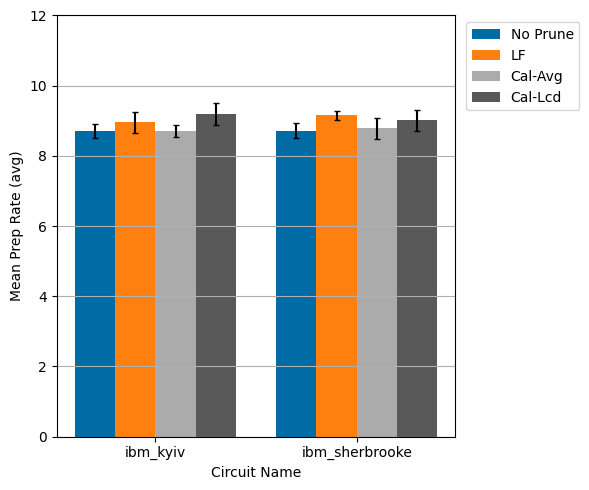

In [35]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "avg", [0,12],show_data="prune", xlabel="Circuit Name")

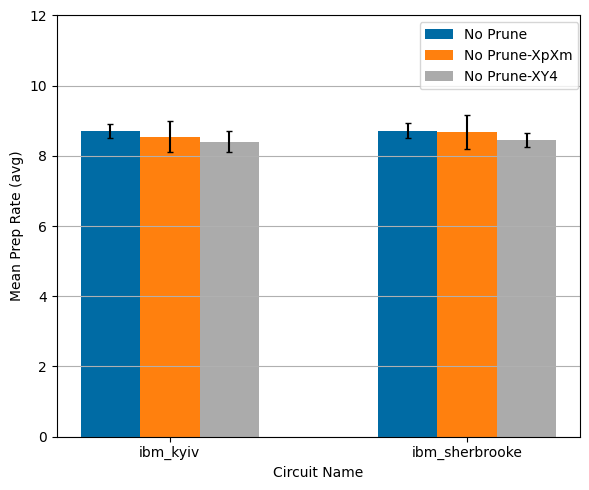

In [36]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "avg", [0,12],show_data="dd", xlabel="Circuit Name")

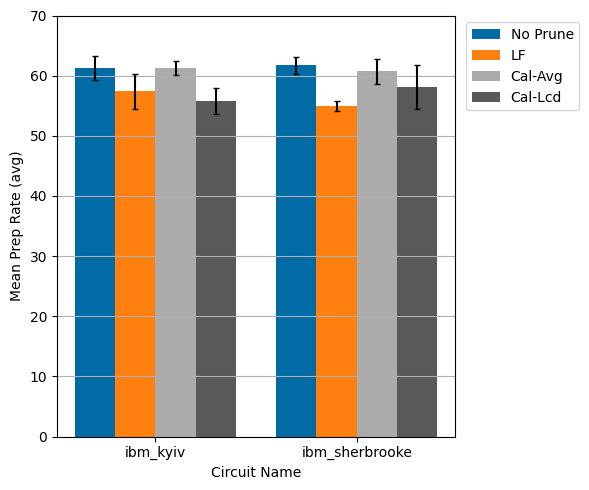

In [37]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "all", [0,70],show_data="prune", xlabel="Circuit Name")

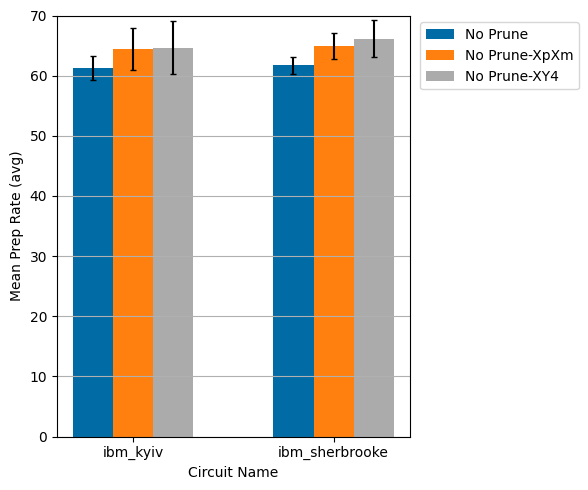

In [38]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "all", [0,70],show_data="dd", xlabel="Circuit Name")

# Applying M3 to Real Backend Result

In [39]:
hw_name = "ibm_sherbrooke"
backend = service.backend(hw_name)

In [40]:
sql = """
SELECT h.job_id, h.job_completed_datetime, d.id, d.circuit_name, d.initial_mapping, h.shots,
m.success_rate_tvd, j.quasi_dists
FROM framework.result_header h
INNER JOIN framework.result_detail d ON h.id = d.header_id 
INNER JOIN framework.metric m ON d.id = m.detail_id
INNER JOIN framework.result_backend_json j ON d.id = j.detail_id
WHERE h.id = 1277 AND d.id = 13514;
"""

conn = mysql.connector.connect(**mysql_config)
cursor = conn.cursor()

cursor.execute(sql)
    
results = cursor.fetchall()

cursor.close()
conn.close()

In [41]:
job_id, job_completed_datetime, detail_id, circuit_name, initial_mapping, shots, success_rate_tvd, tmp_quasi_dists = results[0]

In [7]:
job  = service.job(job_id)
inputs_pubs = job.inputs["pubs"]

RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum.ibm.com/runtime/jobs/czm00csqw630008tfhng. {"errors":[{"code":1291,"message":"Job not found. Job ID: czm00csqw630008tfhng","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}'

In [8]:
circ_bv = inputs_pubs[0][0]
#circ_bv.draw("mpl", idle_wires=False, fold=-1)

NameError: name 'inputs_pubs' is not defined

In [308]:
mappings = {}
for idx, i in enumerate(initial_mapping.split(", ")):
    mappings[idx] = int(i)

mappings

{0: 93, 1: 86, 2: 88, 3: 87}

In [309]:
quasi_dists = json.loads(tmp_quasi_dists)
dists_count = {key: round(value * shots) for key, value in quasi_dists.items()}
dists_count

{'15': 3777,
 '0': 36,
 '13': 37,
 '11': 65,
 '3': 16,
 '14': 50,
 '1': 8,
 '7': 9,
 '9': 1,
 '2': 1}

In [313]:
counts = convert_dict_int_to_binary(dists_count, 4)
counts

{'1111': 3777,
 '0000': 36,
 '1101': 37,
 '1011': 65,
 '0011': 16,
 '1110': 50,
 '0001': 8,
 '0111': 9,
 '1001': 1,
 '0010': 1}

## Correction Last Calibration Data

In [314]:
sim_noisy = AerSimulator.from_backend(backend)

In [315]:
mit = mthree.M3Mitigation(sim_noisy)
mit.cals_from_system(mappings, 100000)
counts_m3 = mit.apply_correction(counts, mappings)
counts_m3_count = {key: round(value * shots) for key, value in counts_m3.items()}
counts_m3_count

{'0000': 36,
 '0001': 8,
 '0010': 1,
 '0011': 16,
 '0111': -21,
 '1001': 0,
 '1011': 16,
 '1101': 10,
 '1110': 23,
 '1111': 3910}

## Correction Average

In [42]:
hw_name = "ibm_fez"
#hw_name = "ibm_sherbrooke"
QiskitRuntimeService.save_account(channel="ibm_cloud", token="tyF4ya7NOGlq9Ls_JM5JJ0vG0IJmdu_Ea2rc-xTauvJ_", 
                                  instance="ibm_credit", 
                                  name="handy-kurniawan", set_as_default=False, overwrite=True)

service = QiskitRuntimeService(channel="ibm_cloud", token="tyF4ya7NOGlq9Ls_JM5JJ0vG0IJmdu_Ea2rc-xTauvJ_", instance="ibm_credit")
backend = service.backend(hw_name)

In [43]:
properties = backend.properties()
prop_dict = properties.to_dict()


In [44]:
from qiskit.providers.models import BackendProperties

def get_noisy_simulator(backend, 
                        error_percentage: float = 1, 
                        noiseless: bool = False, 
                        method: str ="automatic",
                        readout_error_rate: dict = None):
    _backend = copy.deepcopy(backend)
    _properties = _backend.properties()
    _prop_dict = _properties.to_dict()
    last_update_date = _prop_dict["last_update_date"]
    
    # update readout error
    if readout_error_rate == None:
        for i in _prop_dict["qubits"]:
            for j in i:
                if (j["name"] in ("readout_error", "prob_meas0_prep1", "prob_meas1_prep0")):
                    new_val = j["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    j["value"] = new_val
                    # j["value"] = 0
                    # print(j["name"], j["value"])
                elif (j["name"] in ("T1", "T2")):
                    if error_percentage == 0:
                        new_val = j["value"]  / 0.00001
                    else:
                        new_val = j["value"]  / error_percentage
                    
                    j["value"] = new_val
    else:
        for idx, i in enumerate(_prop_dict["qubits"]):
            for j in i:
                if (j["name"] in ("readout_error", "prob_meas0_prep1", "prob_meas1_prep0")):

                    new_val = readout_error_rate[idx]
                    
                    j["value"] = new_val


                    
    if backend.name in (["ibm_fez", "ibm_marrakesh", "ibm_torino"]):
        for i in _prop_dict["qubits"]:
            dict_frequency = {
                "date": last_update_date,
                "name": "frequency",
                "unit": "GHz",
                "value": 0
            }
            i.append(dict_frequency)
            
            dict_anharmonicity = {
                "date": last_update_date,
                "name": "anharmonicity",
                "unit": "GHz",
                "value": 0
            }
            i.append(dict_anharmonicity)
    
    # update single qubit error
    for i in _prop_dict["gates"]:
        if(i["gate"] != "ecr"):
            pars = i["parameters"]
        
            for par in pars:
                if (par["name"] == "gate_error"):
                    new_val = par["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    # par["value"] = new_val
                    par["value"] = 0
                    # print(i["qubits"], par["value"])
    
    # Update Two Qubit Error
    for i in _prop_dict["gates"]:
        if(i["gate"] == "ecr"):
            pars = i["parameters"]
    
            for par in pars:
                if (par["name"] == "gate_error"):
                    new_val = par["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    par["value"] = new_val
                    # print(i["qubits"], par["value"])
    
    new_properties = BackendProperties.from_dict(_prop_dict)
    new_prop_dict = new_properties.to_dict()
    new_prop_json = json.dumps(new_prop_dict, indent = 0, default=str) 
    new_prop_json = new_prop_json.replace("\n", "")

    coupling_map = _backend.configuration().coupling_map
    # print(coupling_map)
    
    
    
    if backend.name in (["ibm_fez", "ibm_marrakesh", "ibm_torino"]):
        if noiseless or error_percentage == 0.0:
            sim_noisy = AerSimulator()
        else:
            noise_model = NoiseModel.from_backend_properties(new_properties, dt = 0.1)
            
            #sim_noisy = AerSimulator.from_backend(backend=backend)
            sim_noisy = AerSimulator(configuration=_backend.configuration(), properties=new_properties,
                                    noise_model=noise_model, method = method
                                    # max_shot_size=100,method='statevector', max_memory_mb=10000 
                                    )
            sim_noisy.set_options(
                noise_model=noise_model,
                method = method
                # max_shot_size=100, max_memory_mb=10000, method='statevector'
                )

        return None, sim_noisy, coupling_map

    else:
        noise_model = NoiseModel.from_backend_properties(new_properties, dt = 0.1)
        if noiseless or error_percentage == 0.0:
            sim_noisy = AerSimulator()
        else:
            sim_noisy = AerSimulator(configuration=_backend.configuration(), properties=new_properties,
                                    noise_model=noise_model, method = method
                                    # max_shot_size=100,method='statevector', max_memory_mb=10000 
                                    )
            sim_noisy.set_options(
                noise_model=noise_model,
                method = method
                # max_shot_size=100, max_memory_mb=10000, method='statevector'
                )
    
        return noise_model, sim_noisy, coupling_map

/tmp/ipykernel_8960/1181243360.py:1: DeprecationWarning: qiskit.providers.models is deprecated since Qiskit 1.2 and will be removed in Qiskit 2.0. With the removal of Qobj, there is no need for these schema-conformant objects. If you still need to use them, it could be because you are using a BackendV1, which is also deprecated in favor of BackendV2.
  from qiskit.providers.models import BackendProperties


In [45]:
backend.name

'ibm_fez'

In [46]:


sql = f"""
SELECT qubit, AVG(readout_error) FROM (
SELECT DISTINCT qubit, readout_error, readout_error_date FROM calibration_data.ibm_qubit_spec q
INNER JOIN calibration_data.ibm i ON q.calibration_id = i.calibration_id 
WHERE i.hw_name = "{backend.name}" AND readout_error_date BETWEEN date_add(now(), INTERVAL -30 DAY) AND now()
) X GROUP BY qubit;
"""

conn = mysql.connector.connect(**mysql_config_online)
cursor = conn.cursor()

# insert to circuit
cursor.execute(sql)

results = cursor.fetchall()

cursor.close()
conn.close()

avg_readout_error_rate = {}

for res in results:
    qubit, err_rate = res

    avg_readout_error_rate[qubit] = np.float64(err_rate)

# ----------------------------------

# get calibration data from certain date


conn = mysql.connector.connect(**mysql_config_online)
cursor = conn.cursor()

sql = f"""
SELECT calibration_id FROM calibration_data.ibm 
WHERE calibration_datetime <= "{job_completed_datetime}" AND hw_name = "{backend.name}" 
ORDER BY calibration_datetime DESC LIMIT 1;
"""


cursor.execute(sql)
results = cursor.fetchall()
cal_id = results[0][0]

print(cal_id)

sql = f"""
SELECT qubit, readout_error FROM calibration_data.ibm_qubit_spec q
INNER JOIN calibration_data.ibm i ON q.calibration_id = i.calibration_id 
WHERE i.hw_name = "{backend.name}" AND i.calibration_id = {cal_id};
"""

cursor.execute(sql)
results = cursor.fetchall()

cursor.close()
conn.close()

lcd_readout_error_rate = {}

for res in results:
    qubit, err_rate = res

    lcd_readout_error_rate[qubit] = np.float64(err_rate)



_, sim_noisy_avg_readout, _ = get_noisy_simulator(backend, 1, False, "automatic", avg_readout_error_rate)
_, sim_noisy_lcd_readout, _ = get_noisy_simulator(backend, 1, False, "automatic", lcd_readout_error_rate)

71396


In [47]:
cal_id

71396

In [318]:
mit_avg = mthree.M3Mitigation(sim_noisy_avg_readout)
mit_avg.cals_from_system(mappings, 200000)
#quasis_avg = mit_avg.apply_correction(counts, mappings, distance=10, return_mitigation_overhead=True, details=True)
counts_m3_avg = mit_avg.apply_correction(counts, mappings)
counts_m3_avg_count = {key: round(value * shots) for key, value in counts_m3_avg.items()}
counts_m3_avg_count

{'0000': 36,
 '0001': 8,
 '0010': 1,
 '0011': 16,
 '0111': -34,
 '1001': 0,
 '1011': 20,
 '1101': 11,
 '1110': 18,
 '1111': 3924}

In [319]:
mit_lcd = mthree.M3Mitigation(sim_noisy_lcd_readout)
mit_lcd.cals_from_system(mappings, 200000)
#quasis_avg = mit_avg.apply_correction(counts, mappings, distance=10, return_mitigation_overhead=True, details=True)
counts_m3_lcd = mit_lcd.apply_correction(counts, mappings)
counts_m3_lcd_count = {key: round(value * shots) for key, value in counts_m3_lcd.items()}
counts_m3_lcd_count

{'0000': 36,
 '0001': 8,
 '0010': 1,
 '0011': 16,
 '0111': -40,
 '1001': 0,
 '1011': 21,
 '1101': 8,
 '1110': 22,
 '1111': 3927}

In [321]:
correct_answer = "1111"
print(counts[correct_answer]/shots)
print(counts_m3_count[correct_answer]/shots)
print(counts_m3_lcd_count[correct_answer]/shots)
print(counts_m3_avg_count[correct_answer]/shots)


0.94425
0.9775
0.98175
0.981


## For Polar

In [66]:
sql = """
SELECT h.hw_name, h.qiskit_token, h.job_id, h.job_completed_datetime, d.id, d.circuit_name, d.initial_mapping, h.shots,
m.polar_count_accept, j.quasi_dists
FROM framework.result_header h
INNER JOIN framework.result_detail d ON h.id = d.header_id 
INNER JOIN framework.metric m ON d.id = m.detail_id
INNER JOIN framework.result_backend_json j ON d.id = j.detail_id
WHERE h.id = 1718 AND d.id = 15977;
"""

conn = mysql.connector.connect(**mysql_config)
cursor = conn.cursor()

cursor.execute(sql)
    
results = cursor.fetchall()

cursor.close()
conn.close()

hw_name, token, job_id, job_completed_datetime, detail_id, circuit_name, initial_mapping, shots, success_rate_tvd, tmp_quasi_dists = results[0]
quasi_dists = json.loads(tmp_quasi_dists)
dists_count = {key: round(value * shots) for key, value in quasi_dists.items()}

In [67]:
counts = convert_dict_int_to_binary(dists_count, 20)
counts_ancilla = sum_middle_digits_dict(counts, -12, None)
job_id

'czn9stzp3xeg008hdys0'

In [68]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.backend(hw_name)

In [50]:
from qiskit.providers.models import BackendProperties


def get_noisy_simulator(backend, 
                        error_percentage: float = 1, 
                        noiseless: bool = False, 
                        method: str ="automatic",
                        readout_error_rate: dict = None):
    _backend = copy.deepcopy(backend)
    _properties = _backend.properties()
    _prop_dict = _properties.to_dict()

    
    
    # update readout error
    if readout_error_rate == None:
        for i in _prop_dict["qubits"]:
            for j in i:
                if (j["name"] in ("readout_error", "prob_meas0_prep1", "prob_meas1_prep0")):
                    new_val = j["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    j["value"] = new_val
                    # j["value"] = 0
                    # print(j["name"], j["value"])
                elif (j["name"] in ("T1", "T2")):
                    if error_percentage == 0:
                        new_val = j["value"]  / 0.00001
                    else:
                        new_val = j["value"]  / error_percentage
                    
                    j["value"] = new_val
    else:
        for idx, i in enumerate(_prop_dict["qubits"]):
            for j in i:
                if (j["name"] in ("readout_error", "prob_meas0_prep1", "prob_meas1_prep0")):

                    new_val = readout_error_rate[idx]
                    
                    j["value"] = new_val


                    
        pass

    # print(_prop_dict["qubits"][0])
    
    # update single qubit error
    for i in _prop_dict["gates"]:
        if(i["gate"] != "ecr"):
            pars = i["parameters"]
        
            for par in pars:
                if (par["name"] == "gate_error"):
                    new_val = par["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    # par["value"] = new_val
                    par["value"] = 0
                    # print(i["qubits"], par["value"])
    
    # Update Two Qubit Error
    for i in _prop_dict["gates"]:
        if(i["gate"] == "ecr"):
            pars = i["parameters"]
    
            for par in pars:
                if (par["name"] == "gate_error"):
                    new_val = par["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    par["value"] = new_val
                    # print(i["qubits"], par["value"])
    
    new_properties = BackendProperties.from_dict(_prop_dict)
    new_prop_dict = new_properties.to_dict()
    new_prop_json = json.dumps(new_prop_dict, indent = 0, default=str) 
    new_prop_json = new_prop_json.replace("\n", "")

    coupling_map = _backend.configuration().coupling_map
    # print(coupling_map)
    
    
    
    if backend.name in (["ibm_fez", "ibm_marrakesh", "ibm_torino"]):
        if noiseless or error_percentage == 0.0:
            sim_noisy = AerSimulator()
        else:
            sim_noisy = AerSimulator.from_backend(backend=backend)

        return None, sim_noisy, coupling_map

    else:
        noise_model = NoiseModel.from_backend_properties(new_properties, dt = 0.1)
        if noiseless or error_percentage == 0.0:
            sim_noisy = AerSimulator()
        else:
            sim_noisy = AerSimulator(configuration=_backend.configuration(), properties=new_properties,
                                    noise_model=noise_model, method = method
                                    # max_shot_size=100,method='statevector', max_memory_mb=10000 
                                    )
            sim_noisy.set_options(
                noise_model=noise_model,
                method = method
                # max_shot_size=100, max_memory_mb=10000, method='statevector'
                )
    
        return noise_model, sim_noisy, coupling_map

def get_avg_readout_error_rate(backend, mysql_config_online):
    sql = f"""
    SELECT qubit, AVG(readout_error) FROM (
    SELECT DISTINCT qubit, readout_error, readout_error_date FROM calibration_data.ibm_qubit_spec q
    INNER JOIN calibration_data.ibm i ON q.calibration_id = i.calibration_id 
    WHERE i.hw_name = "{backend.name}" AND readout_error_date BETWEEN date_add(now(), INTERVAL -30 DAY) AND now()
    ) X GROUP BY qubit;
    """
    
    conn = mysql.connector.connect(**mysql_config_online)
    cursor = conn.cursor()
    
    # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()
    
    avg_readout_error_rate = {}
    
    for res in results:
        qubit, err_rate = res
    
        avg_readout_error_rate[qubit] = np.float64(err_rate)

    return avg_readout_error_rate



# ----------------------------------

def get_readout_error_rate_by_date(backend, job_completed_datetime, mysql_config_online):
    # get calibration data from certain date
    conn = mysql.connector.connect(**mysql_config_online)
    cursor = conn.cursor()
    
    sql = f"""
    SELECT calibration_id FROM calibration_data.ibm 
    WHERE calibration_datetime <= "{job_completed_datetime}" AND hw_name = "{backend.name}" 
    ORDER BY calibration_datetime DESC LIMIT 1;
    """
    
    cursor.execute(sql)
    results = None
    results = cursor.fetchall()
    cal_id = results[0][0]
    
    
    sql = f"""
    SELECT qubit, readout_error FROM calibration_data.ibm_qubit_spec q
    INNER JOIN calibration_data.ibm i ON q.calibration_id = i.calibration_id 
    WHERE i.hw_name = "{backend.name}" AND i.calibration_id = {cal_id};
    """
    
    cursor.execute(sql)
    results = None
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()
    
    lcd_readout_error_rate = {}
    
    for res in results:
        qubit, err_rate = res
    
        lcd_readout_error_rate[qubit] = np.float64(err_rate)

    return lcd_readout_error_rate


/tmp/ipykernel_8960/2083159318.py:1: DeprecationWarning: qiskit.providers.models is deprecated since Qiskit 1.2 and will be removed in Qiskit 2.0. With the removal of Qobj, there is no need for these schema-conformant objects. If you still need to use them, it could be because you are using a BackendV1, which is also deprecated in favor of BackendV2.
  from qiskit.providers.models import BackendProperties


In [12]:
avg_readout_error_rate = get_avg_readout_error_rate(backend, mysql_config_online)
lcd_readout_error_rate = get_readout_error_rate_by_date(backend, job_completed_datetime, mysql_config_online)

_, sim_noisy_avg_readout, _ = get_noisy_simulator(backend, 1, False, "automatic", avg_readout_error_rate)
_, sim_noisy_lcd_readout, _ = get_noisy_simulator(backend, 1, False, "automatic", lcd_readout_error_rate)

In [71]:
n = 3
lstate = "X"
prep_rate = get_q1prep_sr(n, lstate, counts_ancilla)
prep_rate

0.12625

In [72]:
job  = service.job(job_id)
inputs_pubs = job.inputs["pubs"]

In [73]:
circ = inputs_pubs[0][0]
mappings = mthree.utils.final_measurement_mapping(circ)
mappings = {key: value for idx, (key, value) in enumerate(mappings.items()) if idx < 12 }
print(mappings)

{0: 6, 1: 0, 2: 1, 3: 19, 4: 6, 5: 0, 6: 1, 7: 19, 8: 6, 9: 0, 10: 3, 11: 19}


In [74]:
used_qbs = used_qubits(circ)
used_qbs

[0, 1, 2, 3, 4, 5, 6, 7, 14, 18, 19, 20]

In [75]:
mit = mthree.M3Mitigation(sim_noisy)
mit.cals_from_system(mappings, 100000)
counts_m3 = mit.apply_correction(counts_ancilla, mappings)
counts_m3_count = {key: round(value * shots) for key, value in counts_m3.items()}
prep_rate_m3_curr = get_q1prep_sr(n, lstate, counts_m3_count)
prep_rate_m3_curr

0.12627901172947342

In [76]:
mit_avg = mthree.M3Mitigation(sim_noisy_avg_readout)
mit_avg.cals_from_system(mappings, 200000)
#quasis_avg = mit_avg.apply_correction(counts, mappings, distance=10, return_mitigation_overhead=True, details=True)
counts_m3_avg = mit_avg.apply_correction(counts_ancilla, mappings)
counts_m3_avg_count = {key: round(value * shots) for key, value in counts_m3_avg.items()}
prep_rate_m3_avg = get_q1prep_sr(n, lstate, counts_m3_avg_count)
prep_rate_m3_avg

0.12599601593625498

In [77]:
mit_lcd = mthree.M3Mitigation(sim_noisy_lcd_readout)
mit_lcd.cals_from_system(mappings, 200000)
counts_m3_lcd = mit_lcd.apply_correction(counts_ancilla, mappings)
#counts_m3_lcd = mit_lcd.apply_correction(counts_ancilla, mappings, distance=10, return_mitigation_overhead=True, details=True)
counts_m3_lcd_count = {key: round(value * shots) for key, value in counts_m3_lcd.items()}
prep_rate_m3_lcd = get_q1prep_sr(n, lstate, counts_m3_lcd_count)
prep_rate_m3_lcd

0.12627901172947342

In [78]:
print(prep_rate)
print(prep_rate_m3_curr)
print(prep_rate_m3_avg)
print(prep_rate_m3_lcd)

0.12625
0.12627901172947342
0.12599601593625498
0.12627901172947342


In [79]:
for i in range(127):
    if i in used_qbs:
        print(i, avg_readout_error_rate[i], lcd_readout_error_rate[i])

0 0.007371168870192308 0.00537109375
1 0.01068584735576923 0.00537109375
2 0.011014498197115384 0.0078125
3 0.006610576923076923 0.0048828125
4 0.07742074819711539 0.09375
5 0.020911583533653848 0.0546875
6 0.01805701622596154 0.022216796875
7 0.013108473557692308 0.00927734375
14 0.0086669921875 0.005859375
18 0.005727914663461538 0.008544921875
19 0.040536733774038464 0.0341796875
20 0.05132587139423077 0.12451171875


## Combine all together

In [51]:
from datetime import datetime

def apply_m3_to_backend_result(header_id, service):
    sql = """
    SELECT h.hw_name, h.qiskit_token, h.job_id, h.job_completed_datetime, d.id, d.circuit_name, d.initial_mapping, h.shots,
    m.polar_count_accept, j.quasi_dists, c.correct_output
    FROM framework.result_header h
    INNER JOIN framework.result_detail d ON h.id = d.header_id 
    INNER JOIN framework.metric m ON d.id = m.detail_id
    INNER JOIN framework.result_backend_json j ON d.id = j.detail_id
    INNER JOIN framework.circuit c ON d.circuit_name = c.name
    WHERE h.id = %s AND mp_circuits IS NULL ;
    """
    
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()
    
    cursor.execute(sql, (header_id, ))
        
    results = cursor.fetchall()
    
    now_time = datetime.now().strftime("%Y%m%d%H%M%S")

    for res in results:
        hw_name, token, job_id, job_completed_datetime, detail_id, circuit_name, initial_mapping, shots, success_rate_tvd, tmp_quasi_dists, tmp_correct_output = res

        break 

    backend = service.backend(hw_name)
    avg_readout_error_rate = get_avg_readout_error_rate(backend, mysql_config_online)
    _, sim_noisy_avg_readout, _ = get_noisy_simulator(backend, 1, False, "automatic", avg_readout_error_rate)
    
    for res in results:
        hw_name, token, job_id, job_completed_datetime, detail_id, circuit_name, initial_mapping, shots, success_rate_tvd, tmp_quasi_dists, tmp_correct_output = res
        quasi_dists = json.loads(tmp_quasi_dists)
        dists_count = {key: round(value * shots) for key, value in quasi_dists.items()}
        
        #QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
        #service = QiskitRuntimeService(channel="ibm_quantum", token=token)
        
        print(header_id, hw_name)
        
        #backend = service.backend(hw_name)
    
        ## for polar codes
        #counts = convert_dict_int_to_binary(dists_count, 20)
        #counts_ancilla = sum_middle_digits_dict(counts, -12, None)
        #job_id
    
        sim_noisy = AerSimulator.from_backend(backend)
        
        lcd_readout_error_rate = get_readout_error_rate_by_date(backend, job_completed_datetime, mysql_config_online)
        _, sim_noisy_lcd_readout, _ = get_noisy_simulator(backend, 1, False, "automatic", lcd_readout_error_rate)
    
        mappings = {}
        for idx, i in enumerate(initial_mapping.split(", ")):
            mappings[idx] = int(i)
    
        correct_output = json.loads(tmp_correct_output)
        #correct_output = convert_dict_int_to_binary(correct_output, len(mappings))
    
        # for normal
        # print( circuit_name, mappings) 
        counts = convert_dict_int_to_binary(dists_count, len(mappings))
    
        # for circuit with mid-circuit-measurement needs to be different
        
    
        mit = mthree.M3Mitigation(sim_noisy)
        mit.cals_from_system(mappings, 100000)
        quasi_m3 = mit.apply_correction(counts, mappings)
        counts_m3 = {key: round(value * shots) for key, value in quasi_m3.items()}
    
        mit_avg = mthree.M3Mitigation(sim_noisy_avg_readout)
        mit_avg.cals_from_system(mappings, 100000)
        quasi_m3_avg = mit_avg.apply_correction(counts, mappings)
        counts_m3_avg = {key: round(value * shots) for key, value in quasi_m3_avg.items()}
    
        mit_lcd = mthree.M3Mitigation(sim_noisy_lcd_readout)
        mit_lcd.cals_from_system(mappings, 100000)
        quasi_m3_lcd = mit_lcd.apply_correction(counts, mappings)
        counts_m3_lcd = {key: round(value * shots) for key, value in quasi_m3_lcd.items()}
    
    
        tvd_m3_cur = float(calculate_success_rate_tvd(correct_output, convert_dict_binary_to_int(quasi_m3)))
        tvd_m3_avg = float(calculate_success_rate_tvd(correct_output, convert_dict_binary_to_int(quasi_m3_avg)))
        tvd_m3_lcd = float(calculate_success_rate_tvd(correct_output, convert_dict_binary_to_int(quasi_m3_lcd)))
    
        sql_insert = """
        INSERT INTO mitigation(detail_id, type, calibration, fidelity, created_datetime)
        VALUES (%s, %s, %s, %s, %s);
        """
    
        
        cursor.execute(sql_insert, (detail_id, "M3", "cur", tvd_m3_cur, now_time))
        cursor.execute(sql_insert, (detail_id, "M3", "avg", tvd_m3_avg, now_time))
        cursor.execute(sql_insert, (detail_id, "M3", "lcd", tvd_m3_lcd, now_time))
            
        conn.commit()
        
    cursor.close()
    conn.close()
    

    


In [53]:
sql = """
SELECT DISTINCT h.hw_name, h.id
FROM framework.result_header h
INNER JOIN framework.result_detail d ON h.id = d.header_id 
LEFT JOIN framework.mitigation mi ON d.id = mi.detail_id
WHERE h.user_id IN (4, 6) AND d.mp_circuits IS NULL AND mi.fidelity IS NULL 
-- AND hw_name IN ("ibm_brisbane", "ibm_sherbrooke")
AND hw_name IN ("ibm_fez", "ibm_marrakesh", "ibm_torino")
;
"""

conn = mysql.connector.connect(**mysql_config)
cursor = conn.cursor()

cursor.execute(sql)
    
results = cursor.fetchall()

cursor.close()
conn.close()

QiskitRuntimeService.save_account(channel="ibm_cloud", token="tyF4ya7NOGlq9Ls_JM5JJ0vG0IJmdu_Ea2rc-xTauvJ_", 
                                  instance="ibm_credit", 
                                  name="handy-kurniawan", set_as_default=False, overwrite=True)

service = QiskitRuntimeService(channel="ibm_cloud", token="tyF4ya7NOGlq9Ls_JM5JJ0vG0IJmdu_Ea2rc-xTauvJ_", instance="ibm_credit")

for res in results:
    hw_name, header_id = res
    apply_m3_to_backend_result(header_id, service)


# Figure for M3

In [168]:
def get_data_calibration_m3(user_id, circuit_name=None, hw_name=None):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    sql = f"""
    SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name, 
hw_name, circuit_name, compilation_name, 
CONCAT(prune_type, "-" , dd_sequence_type, "-", mit_type, "-", calibration) AS run_type,
COALESCE(mp_circuits, 0), fidelity, circuit_depth, total_two_qubit_gate
FROM(
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, mp_circuits, 
COALESCE(prune_type, "no-prune") AS prune_type, 
mi.type AS mit_type, mi.calibration, mi.fidelity, circuit_depth, total_two_qubit_gate
FROM framework.result_header h
INNER JOIN framework.result_detail d ON h.id = d.header_id 
INNER JOIN framework.metric m ON d.id = m.detail_id
INNER JOIN framework.result_backend_json j ON d.id = j.detail_id
LEFT JOIN framework.mitigation mi ON d.id = mi.detail_id
WHERE h.user_id IN ({user_id}) AND mp_circuits IS NULL 
 AND status = "done" AND circuit_name != "merged" AND mi.fidelity IS NOT NULL
UNION 
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, mp_circuits, 
COALESCE(prune_type, "no-prune") AS prune_type, "" AS mit_type, "" AS calibration,
success_rate_tvd AS fidelity, circuit_depth, total_two_qubit_gate
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" AND circuit_name != "merged"
AND success_rate_tvd IS NOT NULL
)X WHERE 1 = 1 
"""

    if circuit_name != None:
       sql = sql + f""" AND circuit_name = "{circuit_name}" """
    else:
        sql = sql + f""" AND hw_name = "{hw_name}" """


    # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()

    chip_name = []
    hw_name = []
    circuit_name = []
    compilation_name = []
    mp_circuits = []
    run_type = []
    success_rate_tvd = []
    circuit_depth = []
    total_two_qubit_gate = []
    
    for res in results:
        _chip_name, _hw_name, _circuit_name, _compilation_name, _run_type, _mp_circuits, _success_rate_tvd, _circuit_depth, _total_two_qubit_gate = res
    
        chip_name.append(_chip_name)
        hw_name.append(_hw_name)
        circuit_name.append(_circuit_name)
        compilation_name.append(_compilation_name)
        mp_circuits.append(_mp_circuits)
        run_type.append(_run_type)
        success_rate_tvd.append(float(_success_rate_tvd) * 100)
        circuit_depth.append(float(_circuit_depth))
        total_two_qubit_gate.append(float(_total_two_qubit_gate))

    df = pd.DataFrame({
        'chip_name': chip_name,
        'hw_name': hw_name,
        'circuit_name': circuit_name,
        'compilation_name': compilation_name,
        'prune_type': run_type,
        'mp_circuits': mp_circuits,
        'success_rate_tvd': success_rate_tvd,
        'circuit_depth': circuit_depth,
        'total_two_qubit_gate': total_two_qubit_gate,
        })

    return df

In [169]:
get_data_calibration_m3("4,6", hw_name="ibm_brisbane")

,chip_name,hw_name,circuit_name,compilation_name,prune_type,mp_circuits,success_rate_tvd,circuit_depth,total_two_qubit_gate
0,Eagle,ibm_brisbane,OR_5,qiskit_3,lf-no-dd-M3-cur,0,7.02931,369.0,76.0
1,Eagle,ibm_brisbane,OR_5,qiskit_3,lf-no-dd-M3-avg,0,7.31456,369.0,76.0
2,Eagle,ibm_brisbane,OR_5,qiskit_3,lf-no-dd-M3-lcd,0,7.15769,369.0,76.0
3,Eagle,ibm_brisbane,hs4,qiskit_3,lf-no-dd-M3-cur,0,90.65490,16.0,4.0
4,Eagle,ibm_brisbane,hs4,qiskit_3,lf-no-dd-M3-avg,0,94.82170,16.0,4.0
...,...,...,...,...,...,...,...,...,...
2836,Eagle,ibm_brisbane,AND_5,qiskit_3,lf-no-dd--,0,3.12500,368.0,76.0
2837,Eagle,ibm_brisbane,bv4,qiskit_3,lf-no-dd--,0,81.37500,27.0,4.0
2838,Eagle,ibm_brisbane,adder_n4,qiskit_3,lf-no-dd--,0,87.70000,66.0,16.0
2839,Eagle,ibm_brisbane,fredkin,qiskit_3,lf-no-dd--,0,71.47500,91.0,15.0


In [193]:
def show_summary_bar_lines_m3(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0,
                          file_name="", xlabel = None):
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))

    base_values = None
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 0
            
        opt_data = df[df['prune_type'] == opt]
        # print(opt)
        # print(opt_data)
        # print(CB_color_cycle[i + color_idx_add], i + color_idx_add)
        rects = ax.bar(x + i * width, opt_data['mean'], yerr=opt_data['std'], 
                       color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)

        # Store base values (for the first group)
        if i == 0:
            base_values = opt_data['mean'].values
        else:
            for j, (rect, mean_val, std_val) in enumerate(zip(rects, opt_data['mean'], opt_data['std'])):
                height = rect.get_height()
                base = base_values[j]
                diff_value = mean_val - base
                increase = (diff_value / base) * 100 if base != 0 else 0
                
                # Position the label slightly above the error bar
                label_y = height + std_val + 0.01 * ylim[1]  # Adjust 0.01 to fine-tune spacing
                ax.text(rect.get_x() + rect.get_width() / 2, label_y,
                        f'{diff_value:.1f}', ha='center', va='bottom', fontsize=6, color='red')
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends, bbox_to_anchor=(1.01, 1))
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
    # ax.legend()

    if xlabel:
        plt.xlabel(xlabel)
        
    plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig("./{}.png".format(file_name), dpi=250)
    plt.show()

In [194]:
def plot_summary_by_hw_m3(user_id, hw_name, xlabel=None, dd_type=None, file_name=None):
    df_cal_kyiv = get_data_calibration_m3(user_id, hw_name=hw_name)

    df_cal_kyiv_summary = df_cal_kyiv.groupby(['mp_circuits', 'circuit_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    circuits = df_cal_kyiv_summary['circuit_name'].unique()

    #opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
    #        'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
    #        'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
    #        'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
    #       ]
    #legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
    #           'LF', 'LF-XpXm', 'LF-XY4', 
    #           "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
    #           "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
    #          ]

    if dd_type == None:
        opts = ['no-prune-no-dd--',
                'no-prune-no-dd-M3-cur',
                'no-prune-no-dd-M3-lcd',
                'no-prune-no-dd-M3-avg',
               ]
        legends = ["No M3", 
                   'M3-Cur', 
                   "M3-Lcd", 
                   "M3-Avg", 
                  ]
    else:
        opts = [f'no-prune-{dd_type}--',
                f'no-prune-{dd_type}-M3-cur',
                f'no-prune-{dd_type}-M3-lcd',
                f'no-prune-{dd_type}-M3-avg',
               ]
        legends = [f"{dd_type} ", 
                   f'{dd_type} M3-Cur', 
                   f"{dd_type} M3-Lcd", 
                   f"{dd_type} M3-Avg", 
                  ]

    show_summary_bar_lines_m3(df_cal_kyiv_summary, opts, legends, circuits, [0,110], "Mean fidelity (%)", (8,5), 
                           legend_position=(0.018,0.78),
                           width=0.24, xlabel=xlabel, file_name=file_name)
    
    

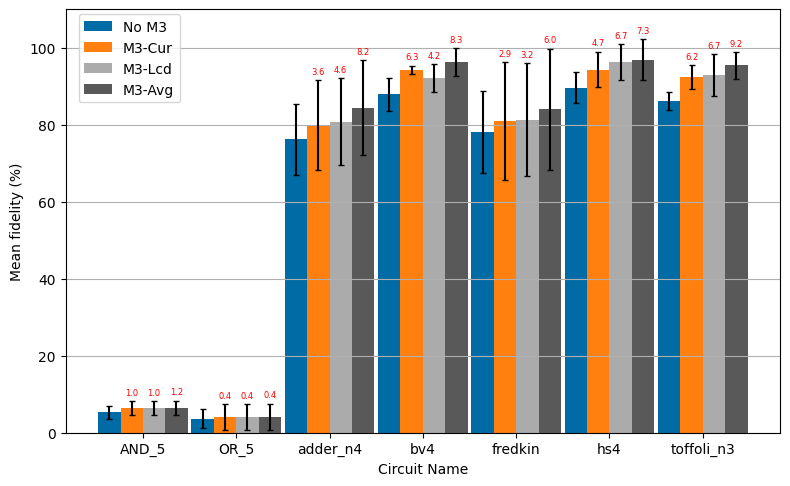

In [195]:
hw_name="ibm_brisbane"
plot_summary_by_hw_m3("4,6", hw_name=hw_name, xlabel="Circuit Name", file_name=f"calibration_circuits_with_m3_{hw_name}")

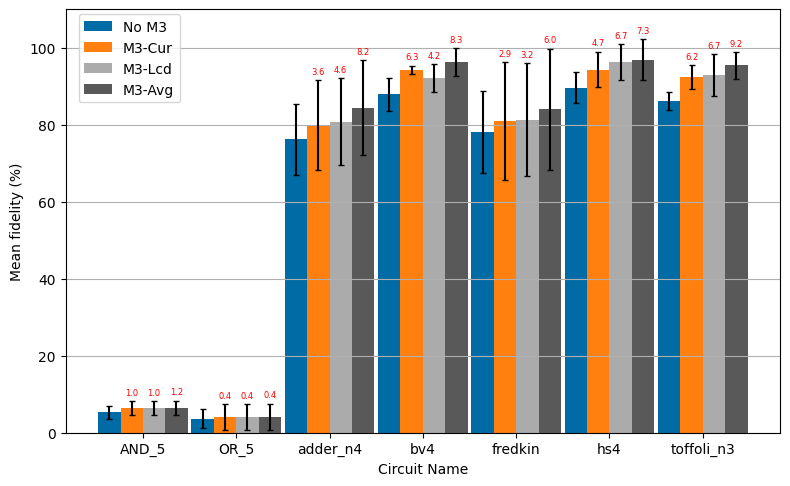

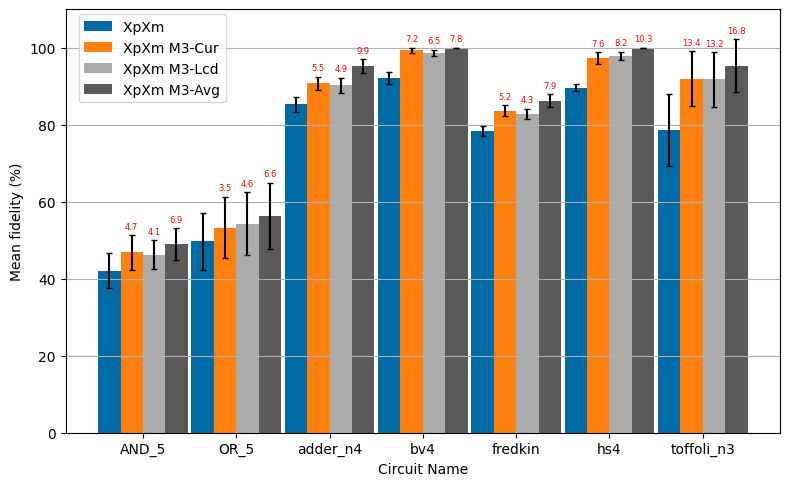

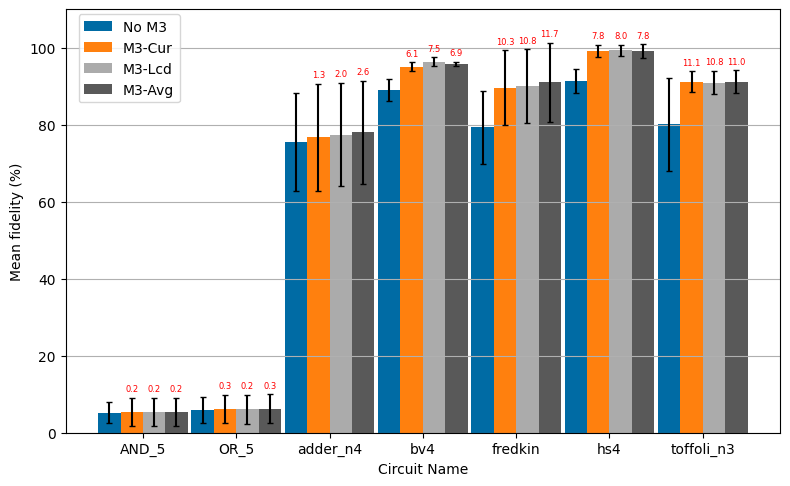

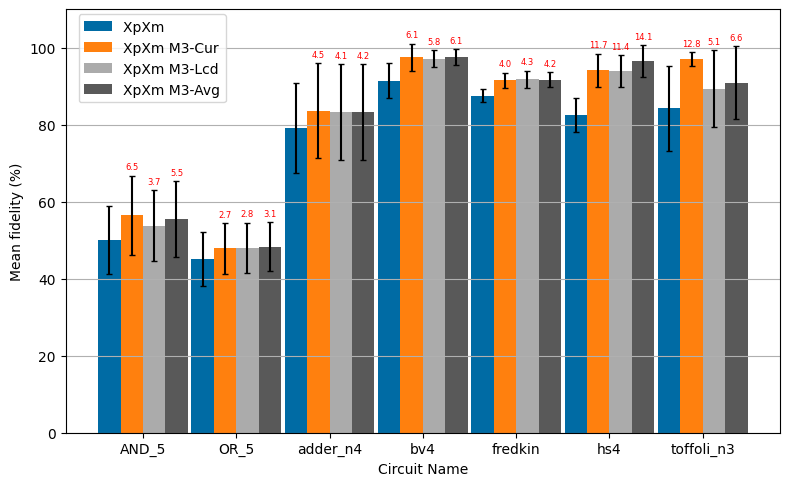

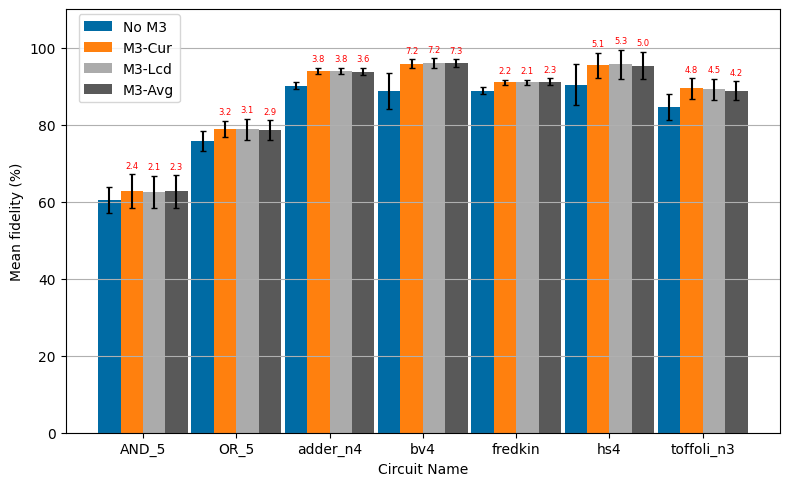

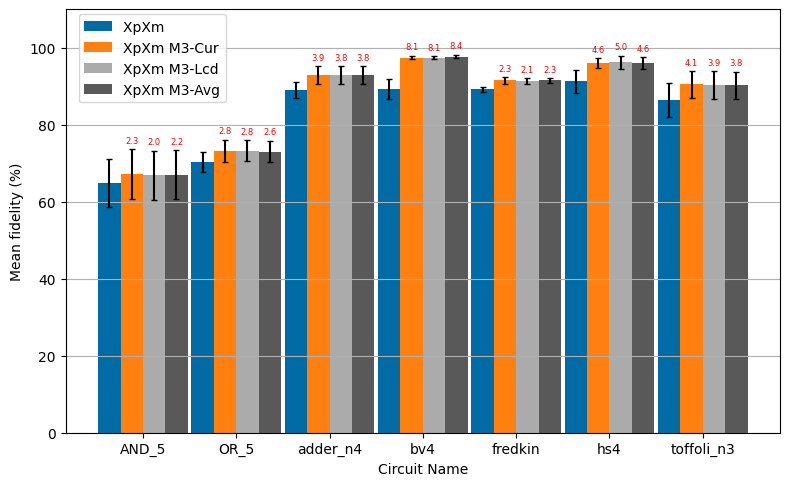

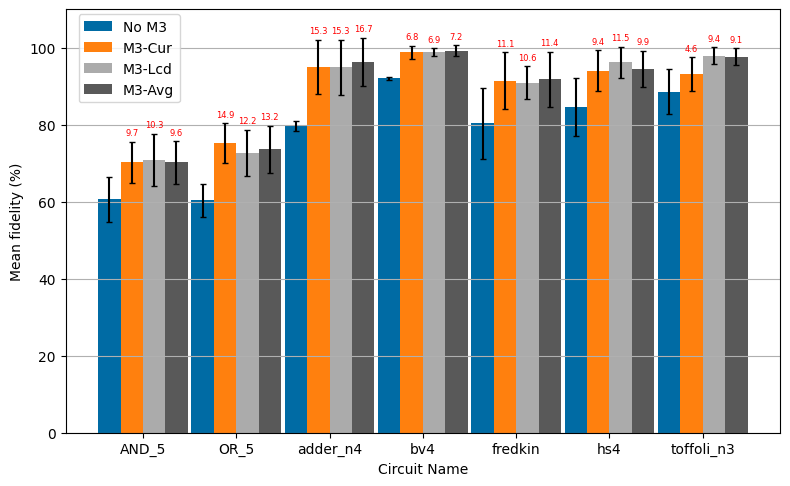

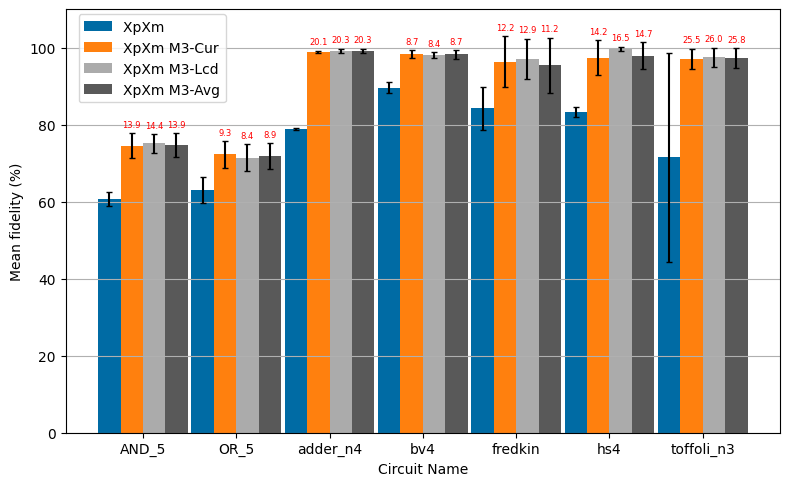

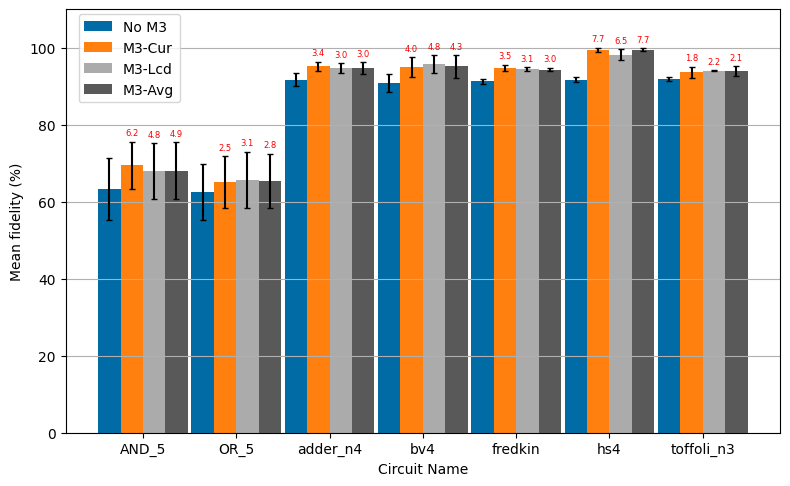

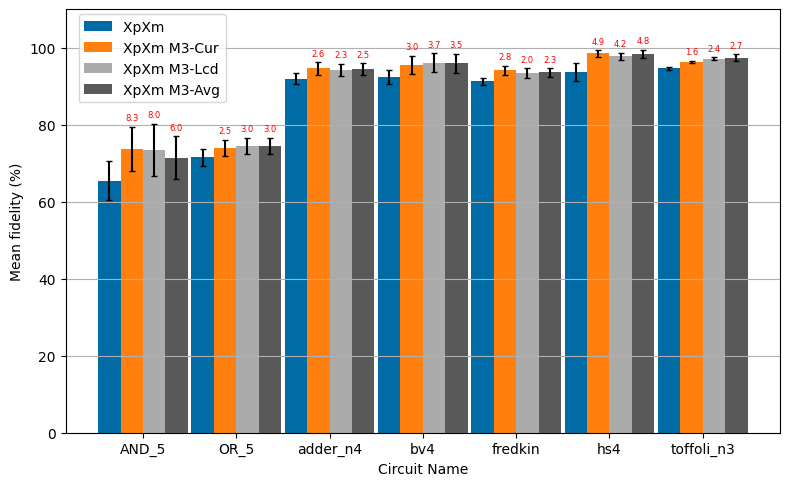

In [192]:
hw_names = ["ibm_brisbane","ibm_sherbrooke","ibm_fez","ibm_torino","ibm_marrakesh"]
for hw_name in hw_names:
    plot_summary_by_hw_m3("4,6", hw_name=hw_name, xlabel="Circuit Name", file_name=f"calibration_circuits_with_m3_{hw_name}")
    plot_summary_by_hw_m3("4,6", hw_name=hw_name, dd_type="XpXm", xlabel="Circuit Name", file_name=f"calibration_circuits_with_xpxm_m3_{hw_name}")

## Quantize the difference

In [61]:
df = get_data_calibration_m3("4,6", hw_name="ibm_brisbane")
df.head()

,chip_name,hw_name,circuit_name,compilation_name,prune_type,mp_circuits,success_rate_tvd,circuit_depth,total_two_qubit_gate
0,Eagle,ibm_brisbane,OR_5,qiskit_3,lf-no-dd-M3-cur,0,0.070293,369.0,76.0
1,Eagle,ibm_brisbane,OR_5,qiskit_3,lf-no-dd-M3-avg,0,0.073146,369.0,76.0
2,Eagle,ibm_brisbane,OR_5,qiskit_3,lf-no-dd-M3-lcd,0,0.071577,369.0,76.0
3,Eagle,ibm_brisbane,hs4,qiskit_3,lf-no-dd-M3-cur,0,0.906549,16.0,4.0
4,Eagle,ibm_brisbane,hs4,qiskit_3,lf-no-dd-M3-avg,0,0.948217,16.0,4.0


In [63]:
df_sum = df.groupby(['mp_circuits', 'circuit_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

In [74]:
opt_data_raw = df_sum[df_sum['prune_type'] == "no-prune-no-dd--"].reset_index()
opt_data_raw

,index,mp_circuits,circuit_name,prune_type,mean,std
0,44,0,AND_5,no-prune-no-dd--,0.052825,0.017230
1,92,0,OR_5,no-prune-no-dd--,0.036125,0.024144
2,140,0,adder_n4,no-prune-no-dd--,0.761900,0.092376
3,188,0,bv4,no-prune-no-dd--,0.878925,0.043146
4,236,0,fredkin,no-prune-no-dd--,0.780325,0.105949
5,284,0,hs4,no-prune-no-dd--,0.896150,0.040883
6,332,0,toffoli_n3,no-prune-no-dd--,0.861525,0.024554


In [75]:
opt_data_M3_cur = df_sum[df_sum['prune_type'] == "no-prune-no-dd-M3-cur"].reset_index()
opt_data_M3_cur

,index,mp_circuits,circuit_name,prune_type,mean,std
0,46,0,AND_5,no-prune-no-dd-M3-cur,0.063013,0.018134
1,94,0,OR_5,no-prune-no-dd-M3-cur,0.040467,0.033125
2,142,0,adder_n4,no-prune-no-dd-M3-cur,0.798310,0.116803
3,190,0,bv4,no-prune-no-dd-M3-cur,0.942312,0.010837
4,238,0,fredkin,no-prune-no-dd-M3-cur,0.809131,0.153461
5,286,0,hs4,no-prune-no-dd-M3-cur,0.943276,0.046296
6,334,0,toffoli_n3,no-prune-no-dd-M3-cur,0.923875,0.031140


In [77]:
opt_data_M3_cur["mean"] - opt_data_raw["mean"]

0    0.010188
1    0.004342
2    0.036410
3    0.063387
4    0.028806
5    0.047126
6    0.062350
Name: mean, dtype: float64

In [82]:
opt_data_M3_cur["mean_diff"] = np.round((opt_data_M3_cur["mean"] - opt_data_raw["mean"]) / opt_data_raw["mean"] * 100,2)

In [83]:
opt_data_M3_cur

,index,mp_circuits,circuit_name,prune_type,mean,std,mean_diff
0,46,0,AND_5,no-prune-no-dd-M3-cur,0.063013,0.018134,19.29
1,94,0,OR_5,no-prune-no-dd-M3-cur,0.040467,0.033125,12.02
2,142,0,adder_n4,no-prune-no-dd-M3-cur,0.798310,0.116803,4.78
3,190,0,bv4,no-prune-no-dd-M3-cur,0.942312,0.010837,7.21
4,238,0,fredkin,no-prune-no-dd-M3-cur,0.809131,0.153461,3.69
5,286,0,hs4,no-prune-no-dd-M3-cur,0.943276,0.046296,5.26
6,334,0,toffoli_n3,no-prune-no-dd-M3-cur,0.923875,0.031140,7.24
